In [209]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import ast
from typing import List, Tuple

from collections import defaultdict
from typing import List                                                                                                         
from tqdm import tqdm

# 30 sec

In [210]:
from Enum.EnergyRange import EnergyRange
from Enum.Flavour import Flavour

In [211]:
sys.path.append('/groups/icecube/cyan/Utils')
from PlotUtils import setMplParam, getColour, getHistoParam 
# getHistoParam:
# Nbins, binwidth, bins, counts, bin_centers  = 
from DB_lister import list_content, list_tables
from ExternalFunctions import nice_string_output, add_text_to_ax
setMplParam()

In [212]:
csvs_high = {
    r"E$\in$(1PeV,100PeV), train(250m), val(250m)": "/groups/icecube/cyan/factory/IceCubeTransformer/predictions/20250409/model_20250326_225437/170015/predictions_epoch_025_val_loss_0.1604.csv"
}
csvs_medium = {
    r"E$\in$(10TeV,1PeV), train(250m), val(250m)": "/groups/icecube/cyan/factory/IceCubeTransformer/predictions/20250409/model_20250326_224941/170633/predictions_epoch_004_val_loss_0.1567.csv"
}

In [213]:
def get_nu_logits(df: pd.DataFrame, flavour: Flavour) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    def safe_parse(x):
        return ast.literal_eval(x) if isinstance(x, str) else x

    df["logits"] = df["logits"].apply(safe_parse)

    nu_e = df[df["target_class"] == 0]
    nu_mu = df[df["target_class"] == 1]
    nu_tau = df[df["target_class"] == 2]

    index = 0 if flavour == Flavour.E else 1 if flavour == Flavour.MU else 2 if flavour == Flavour.TAU else None

    if index is None:
        raise ValueError(f"Unknown flavour: {flavour}")

    nu_e_logit = nu_e["logits"].apply(lambda x: x[index]).to_numpy()
    nu_mu_logit = nu_mu["logits"].apply(lambda x: x[index]).to_numpy()
    nu_tau_logit = nu_tau["logits"].apply(lambda x: x[index]).to_numpy()

    return nu_e_logit, nu_mu_logit, nu_tau_logit


In [214]:
def get_energy(df: pd.DataFrame, flavour: Flavour) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    def safe_parse(x):
        return ast.literal_eval(x) if isinstance(x, str) else x

    df["energy"] = df["energy"].apply(safe_parse)

    nu_e = df[df["target_class"] == 0]
    nu_mu = df[df["target_class"] == 1]
    nu_tau = df[df["target_class"] == 2]

    index = 0 if flavour == Flavour.E else 1 if flavour == Flavour.MU else 2 if flavour == Flavour.TAU else None

    if index is None:
        raise ValueError(f"Unknown flavour: {flavour}")

    nu_e_energy = nu_e["energy"].to_numpy()
    nu_mu_energy = nu_mu["energy"].to_numpy()
    nu_tau_energy = nu_tau["energy"].to_numpy()

    return nu_e_energy, nu_mu_energy, nu_tau_energy

In [215]:
def get_zenith(df:pd.DataFrame, flavour:Flavour) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    def safe_parse(x):
        return ast.literal_eval(x) if isinstance(x, str) else x

    df["zenith"] = df["zenith"].apply(safe_parse) # in radian

    nu_e = df[df["target_class"] == 0]
    nu_mu = df[df["target_class"] == 1]
    nu_tau = df[df["target_class"] == 2]

    index = 0 if flavour == Flavour.E else 1 if flavour == Flavour.MU else 2 if flavour == Flavour.TAU else None

    if index is None:
        raise ValueError(f"Unknown flavour: {flavour}")
    nu_e_zenith = nu_e["zenith"].to_numpy()
    nu_mu_zenith = nu_mu["zenith"].to_numpy()
    nu_tau_zenith = nu_tau["zenith"].to_numpy()
    nu_e_zenith = np.rad2deg(nu_e_zenith)
    nu_mu_zenith = np.rad2deg(nu_mu_zenith)
    nu_tau_zenith = np.rad2deg(nu_tau_zenith)
    return nu_e_zenith, nu_mu_zenith, nu_tau_zenith

In [216]:
def plot_logit_distribution(df: pd.DataFrame, 
                            flavour: Flavour,
                            id: str,
                            manifier: Tuple[float, float] = None) -> None:
    nu_e_logit, nu_mu_logit, nu_tau_logit = get_nu_logits(df, flavour)
    Nbins, binwidth, bins, counts, bin_centers = getHistoParam(nu_e_logit, binwidth=0.005)
    fig, ax = plt.subplots(figsize=(17, 11))
    ax.hist(nu_e_logit, bins=bins, label=fr"${Flavour.E.latex}$", color=getColour(2), histtype='step', linewidth=1)
    ax.hist(nu_mu_logit, bins=bins, label=fr"${Flavour.MU.latex}$", color=getColour(0), histtype='step', hatch='\\', linewidth=1)
    ax.hist(nu_tau_logit, bins=bins, label=fr"${Flavour.TAU.latex}$", color=getColour(1), histtype='step', hatch ='//', linewidth=1)
    
    ax.set_title(fr"${flavour.latex}$ logit Distribution, {id}")
    ax.set_xlabel('Logit')
    ax.set_ylabel('Counts')
    if manifier:
        ax.set_xlim(manifier)
    else:
        ax.set_xlim(-0.1, 1.0)
    d_e = {
        r'$\nu_e$': "",
        "N": len(nu_e_logit),
        "max": np.max(nu_e_logit),
        "min": np.min(nu_e_logit),
        "mean": np.mean(nu_e_logit),
        "median": np.median(nu_e_logit),
        }
    d_mu = {
        r'$\nu_\mu$': "",
        "N": len(nu_mu_logit),
        "max": np.max(nu_mu_logit),
        "min": np.min(nu_mu_logit),
        "mean": np.mean(nu_mu_logit),
        "median": np.median(nu_mu_logit),
        }
    d_tau = {
        r'$\nu_\tau$': "",
        "N": len(nu_tau_logit),
        "max": np.max(nu_tau_logit),
        "min": np.min(nu_tau_logit),
        "mean": np.mean(nu_tau_logit),
        "median": np.median(nu_tau_logit),
        }
    add_text_to_ax(0.2, 0.95, nice_string_output(d_e), ax, fontsize=12)
    add_text_to_ax(0.2, 0.75, nice_string_output(d_mu), ax, fontsize=12)
    add_text_to_ax(0.2, 0.55, nice_string_output(d_tau), ax, fontsize=12)

    ax.legend(fontsize=20)

In [217]:
def plot_csvs(csvs:dict, is_magnifier_on:bool):
    for id, csv in csvs.items():
        df = pd.read_csv(csv)
        plot_logit_distribution(df, Flavour.E, id)
        if is_magnifier_on:
            plot_logit_distribution(df, Flavour.E, id, manifier=(0.8, 1.0))
        plot_logit_distribution(df, Flavour.MU, id)
        if is_magnifier_on:
            plot_logit_distribution(df, Flavour.MU, id, manifier=(0.8, 1.0))
        plot_logit_distribution(df, Flavour.TAU, id)
        if is_magnifier_on:
            plot_logit_distribution(df, Flavour.TAU, id, manifier=(0.8, 1.0))

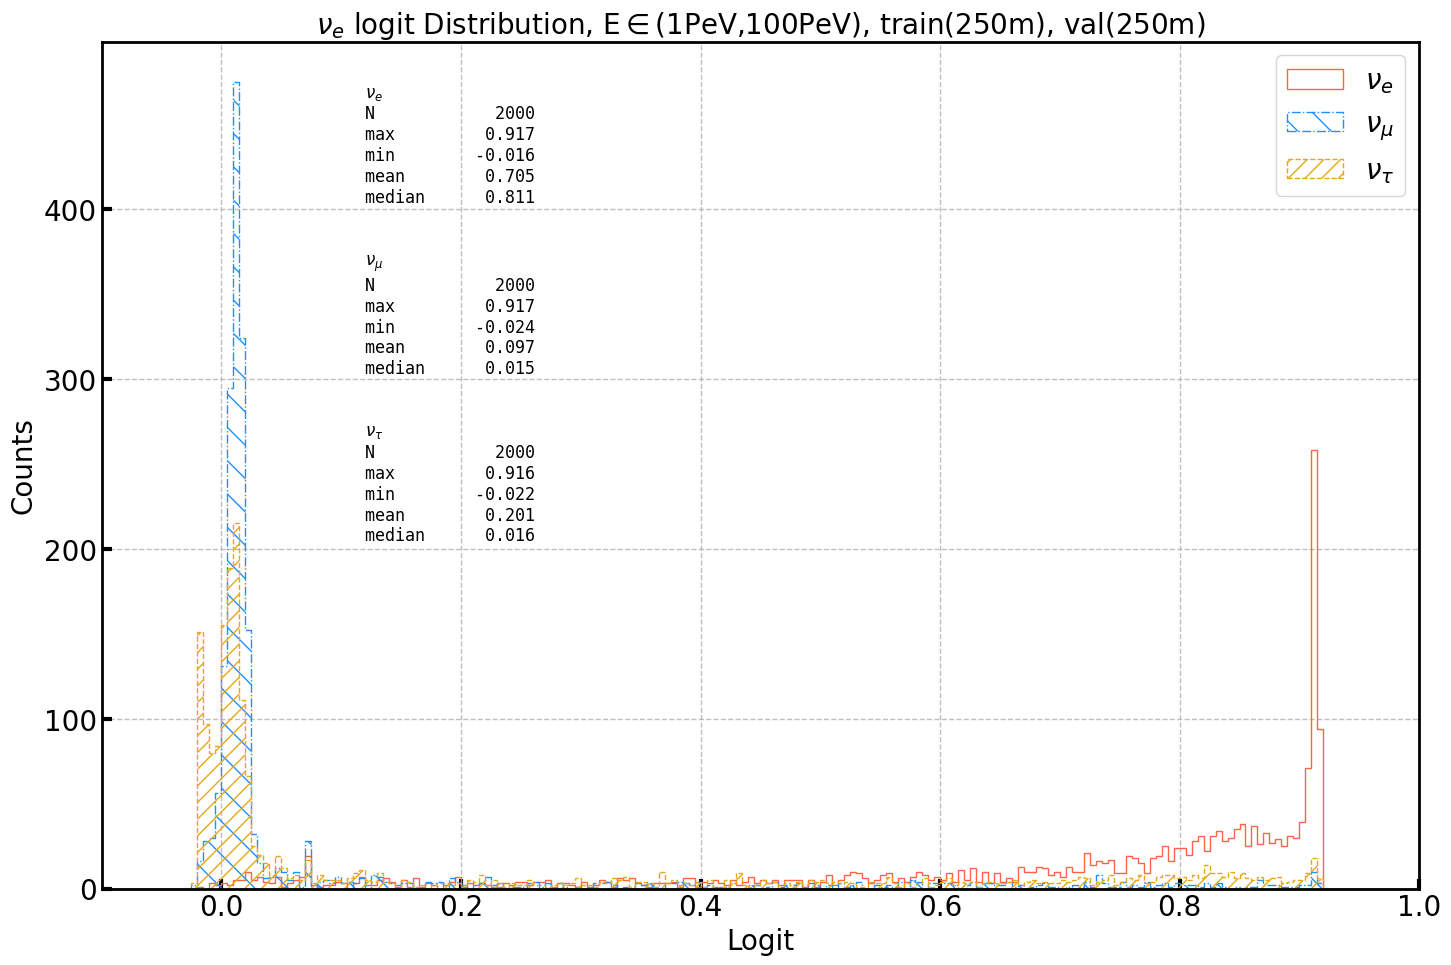

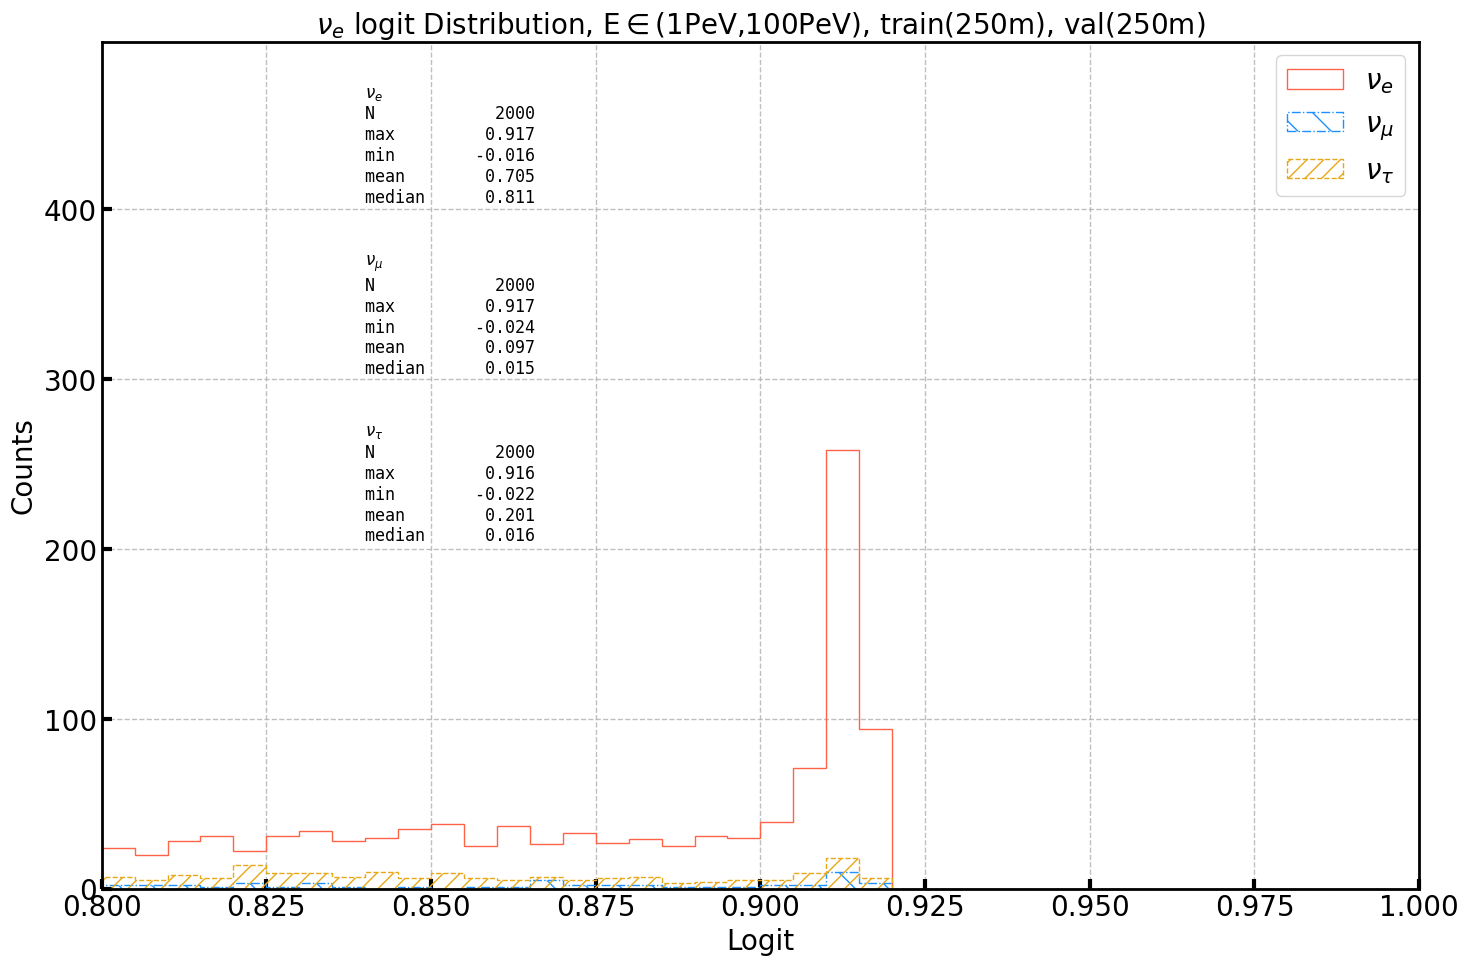

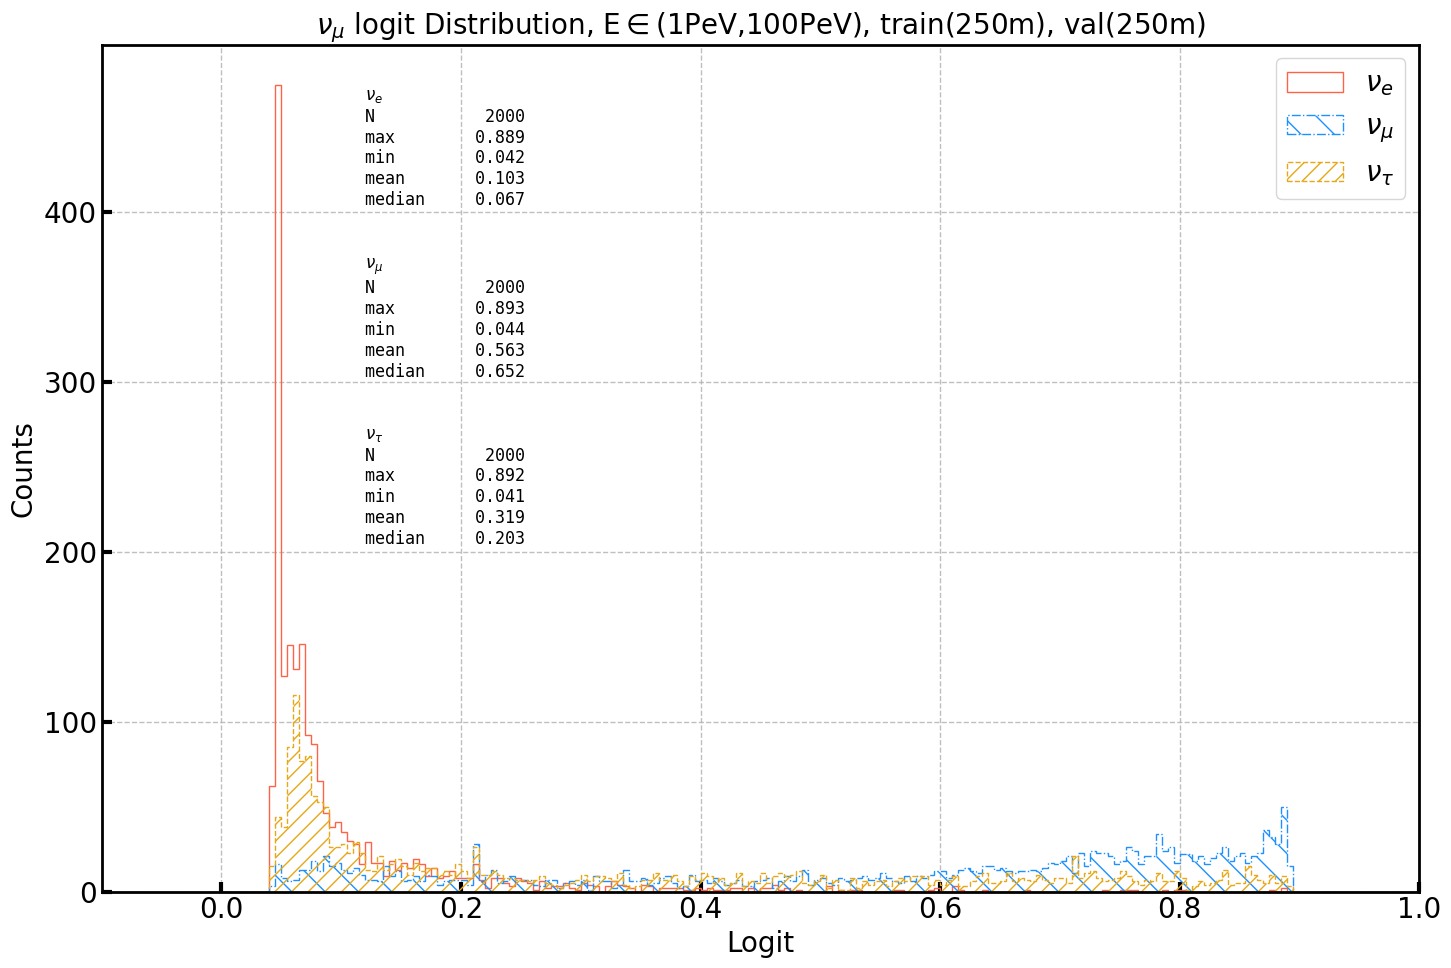

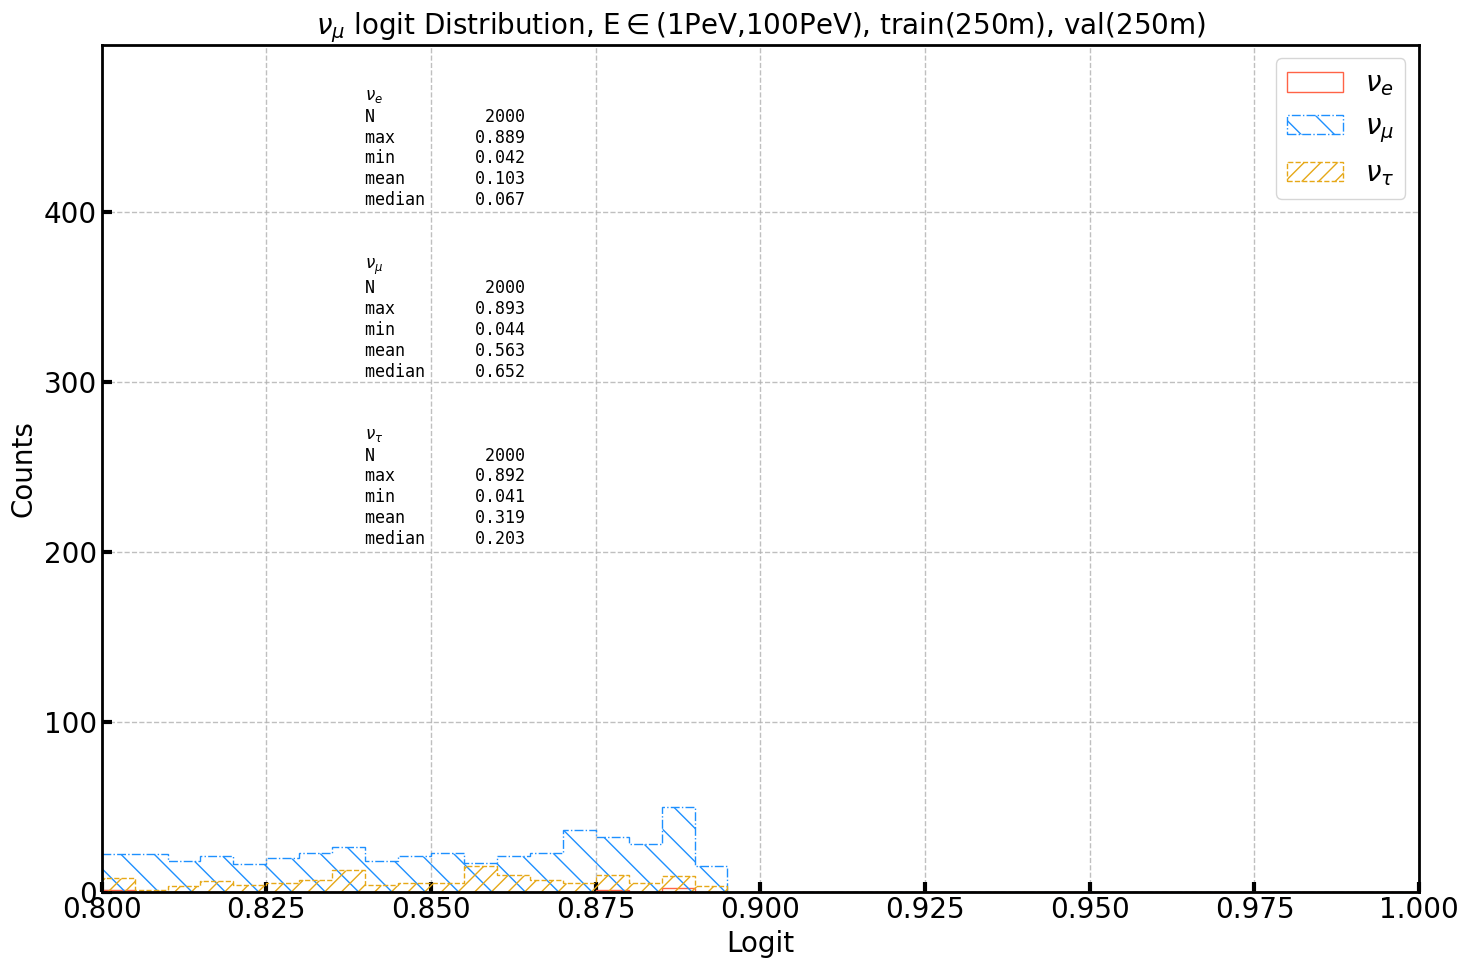

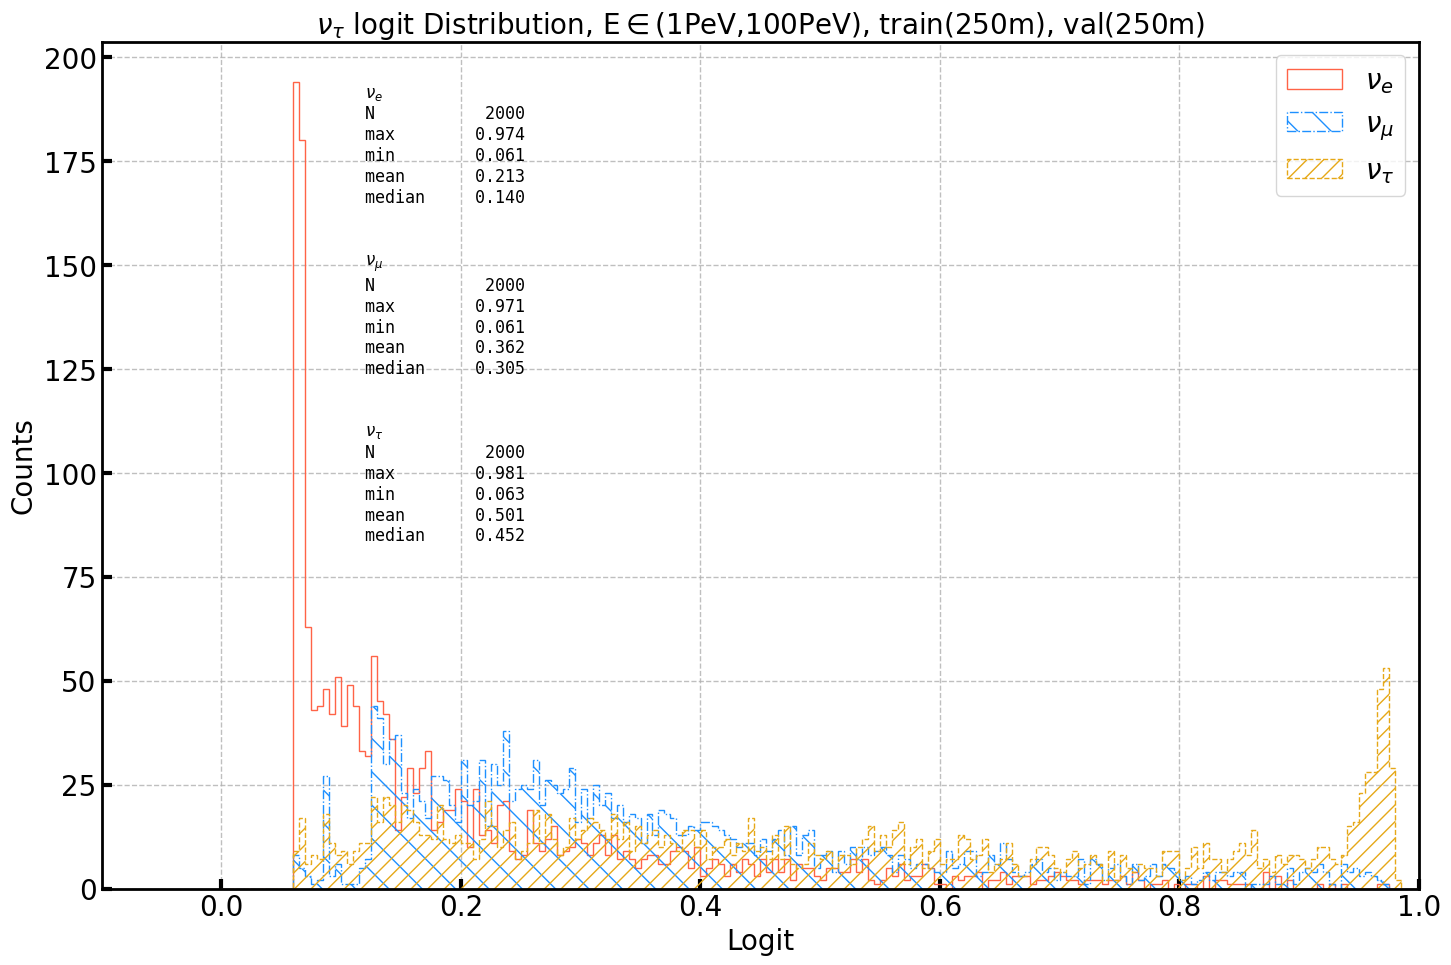

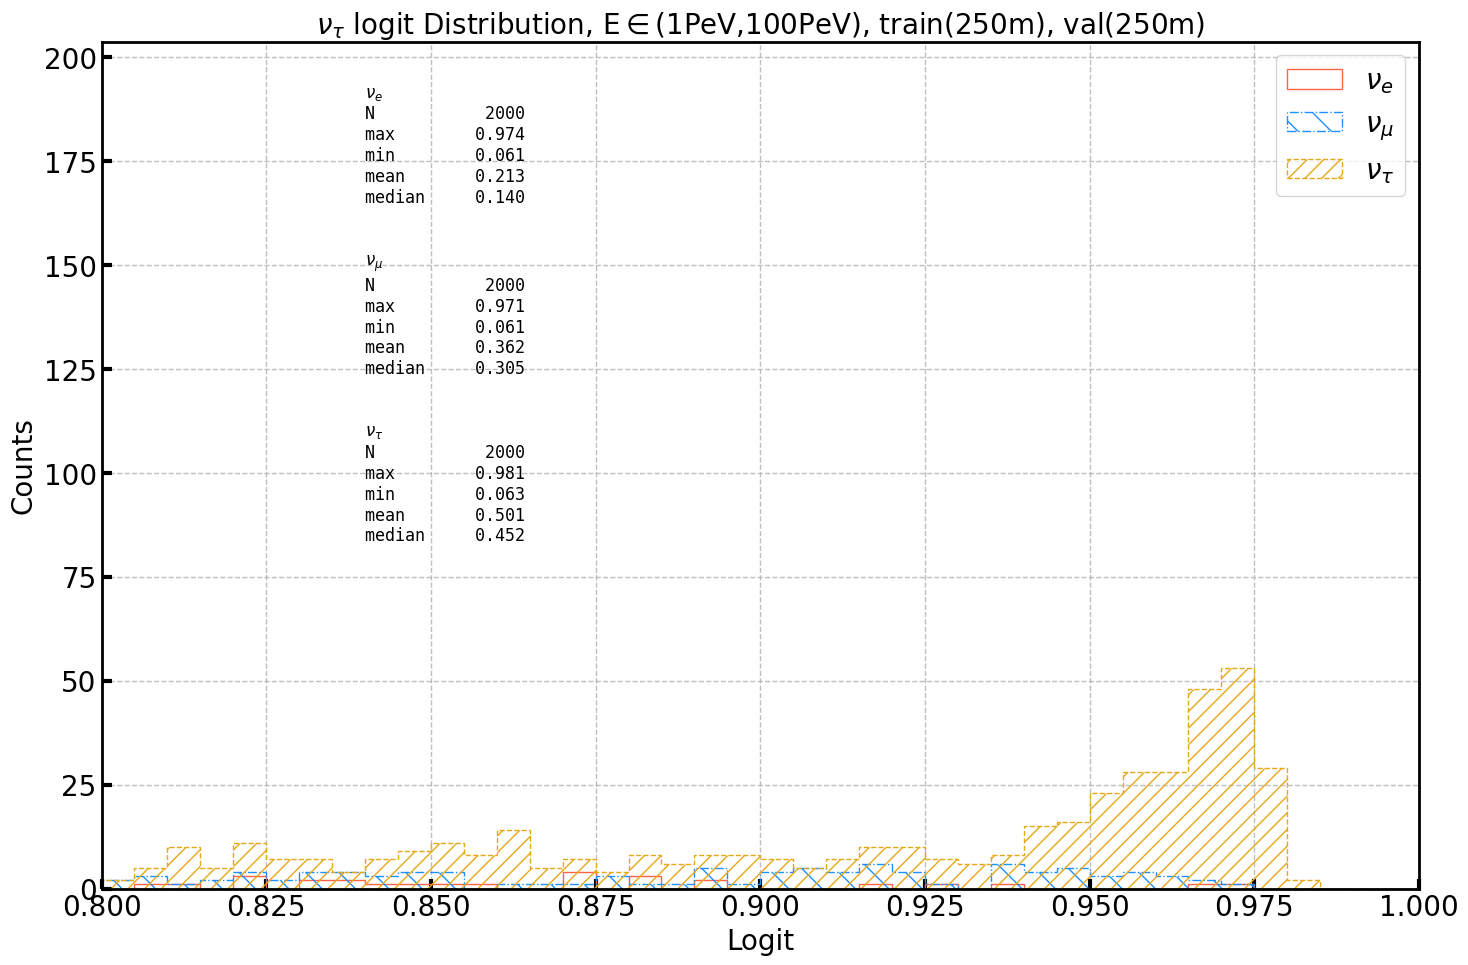

In [218]:
plot_csvs(csvs_high, is_magnifier_on=True)

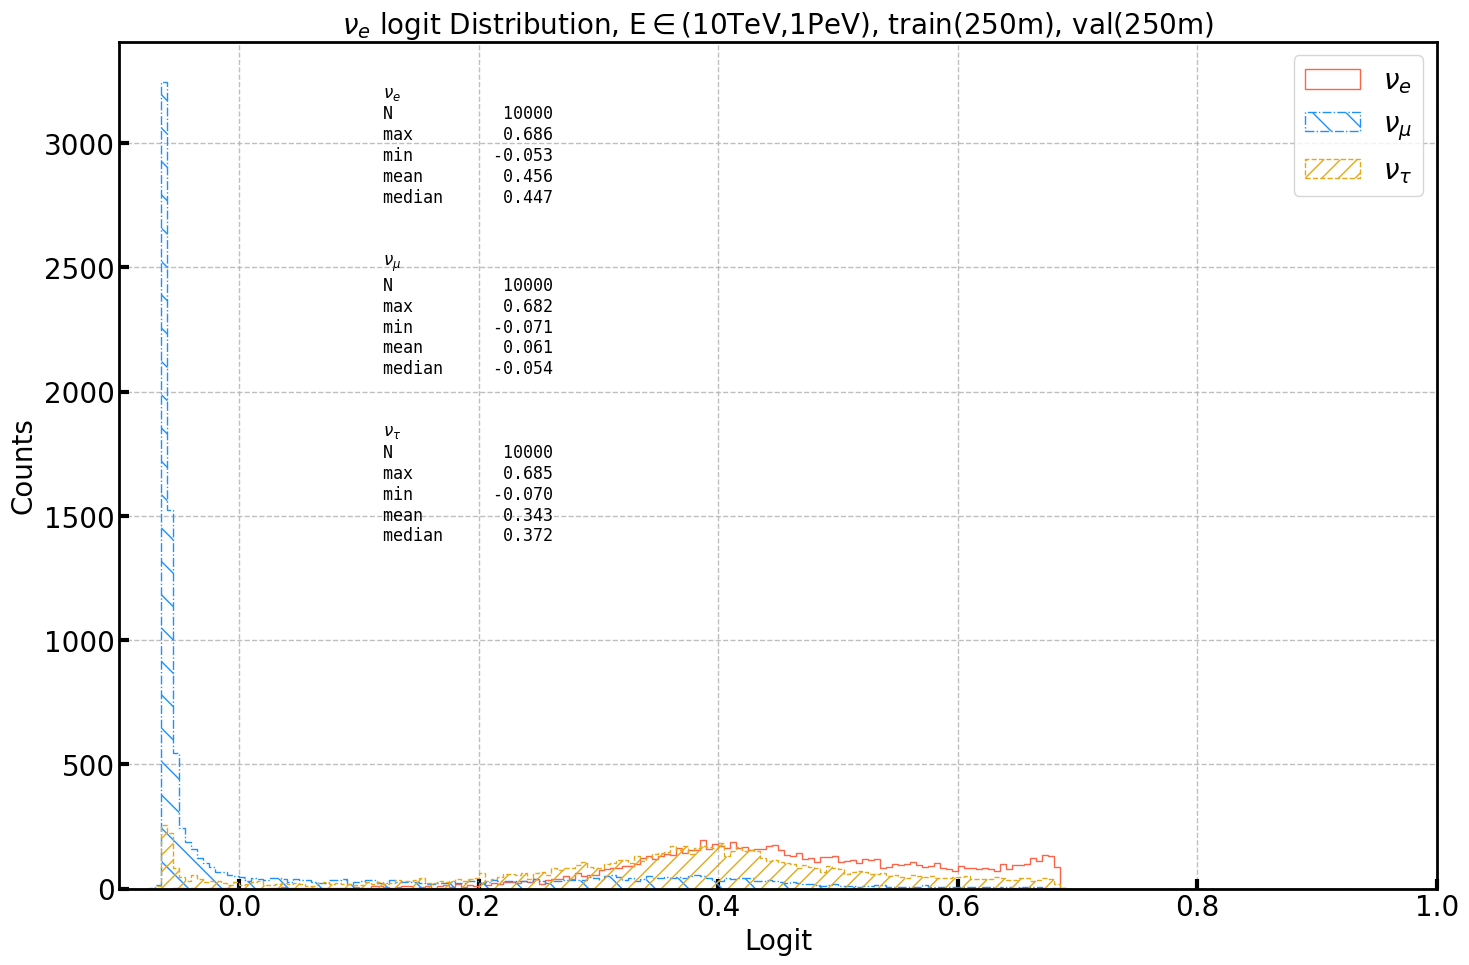

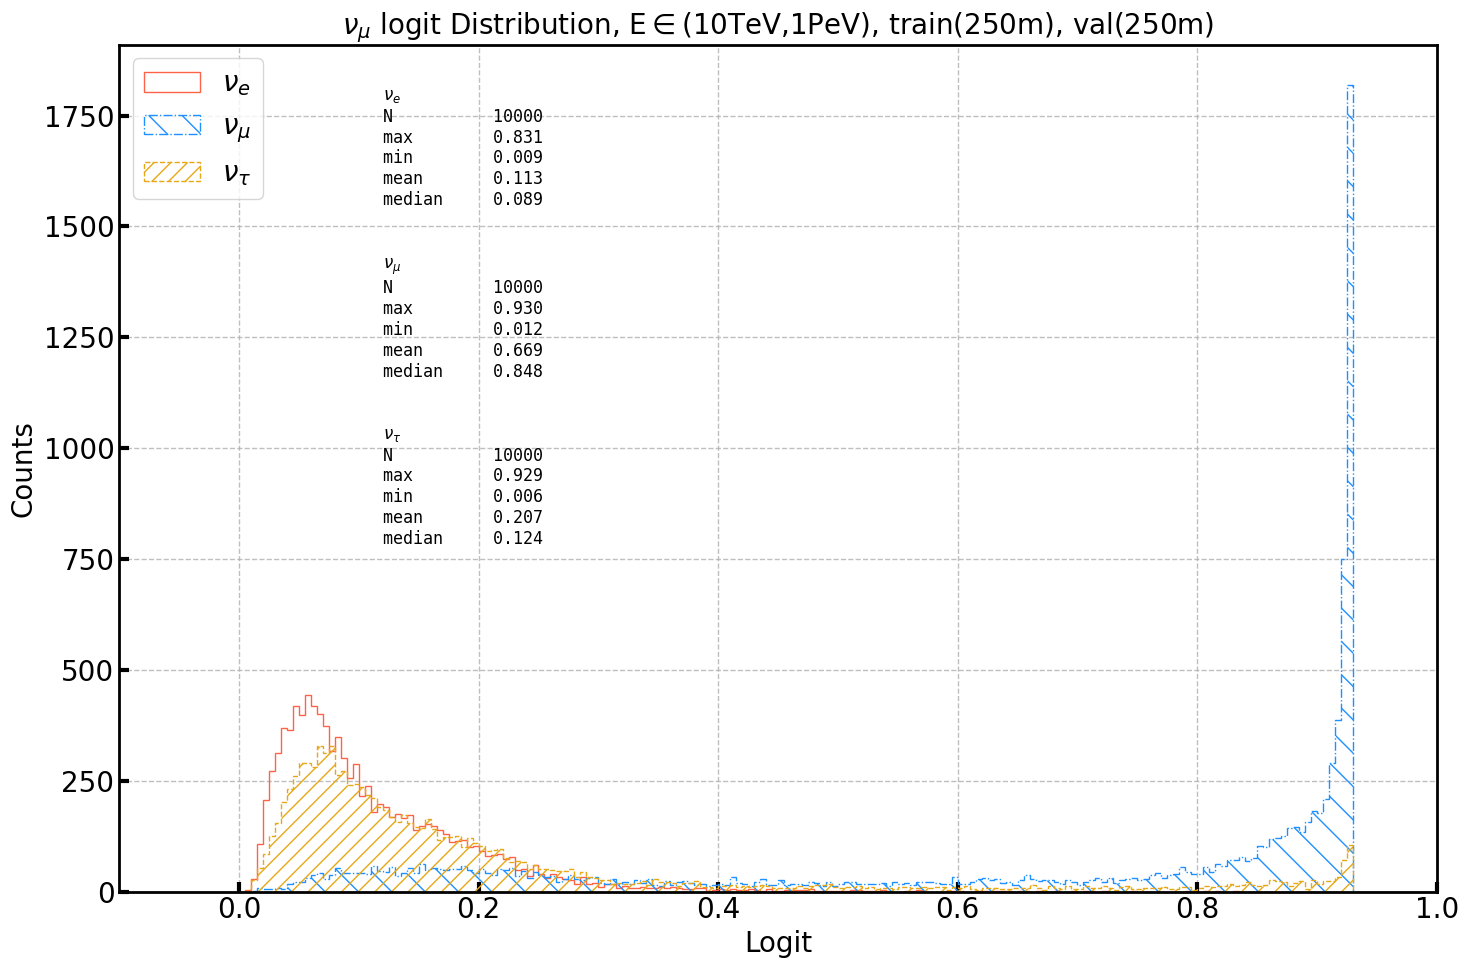

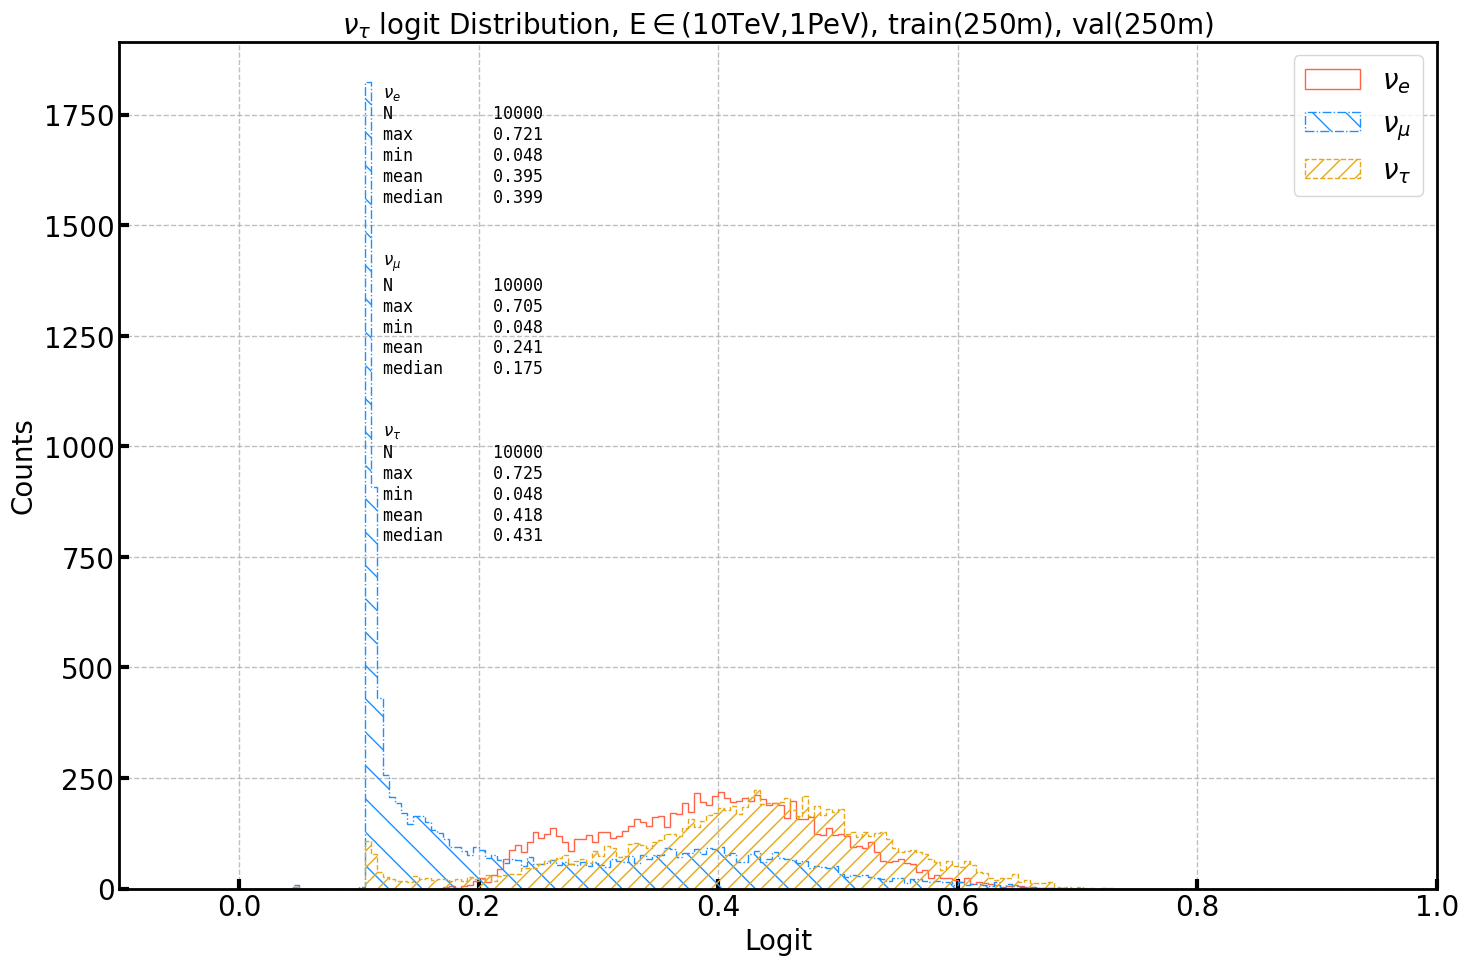

In [219]:
plot_csvs(csvs_medium, is_magnifier_on=False)

In [220]:
def plot_energy_logit_distribution_mono_flavour(nu_logit : np.ndarray,
                                                energy: np.ndarray,
                                                logit_flavour: Flavour,
                                                flavour: Flavour, 
                                                energy_range: EnergyRange,
                                                id: str,
                                                normalise_by_energy: bool = True) -> None:
    Nbins, binwidth, bins, counts, bin_centers = getHistoParam(nu_logit, binwidth=0.1)
    log_energy_binwidth = 0.25
    log_energy = np.log10(energy)
    log_energy_bin = np.arange(np.min(log_energy), np.max(log_energy), log_energy_binwidth)

    H, xedges, yedges = np.histogram2d(nu_logit, log_energy, bins=[bins, log_energy_bin])
    
    if normalise_by_energy:
        # Normalize each row (each energy bin)
        H = H / (H.sum(axis=0, keepdims=True) + 1e-8)  # prevent div-by-zero

    fig, ax = plt.subplots(figsize=(17, 11))
    mesh = ax.pcolormesh(xedges, yedges, H.T, cmap='YlGnBu', shading='auto')

    fig.colorbar(mesh, ax=ax, label="Counts" if not normalise_by_energy else "Counts normalised within energy bin")
    ax.set_title(fr"Energy–logit ${logit_flavour.latex}$ distribution of true ${flavour.latex}$, {id}")
    ax.set_xlabel('Logit')
    ax.set_ylabel('log(Energy[GeV])')
    ax.set_xlim(-0.1, 1.0)

    if energy_range == EnergyRange.ER_1_PEV_100_PEV:
        log_energy_min = 6
        log_energy_max = 8
    elif energy_range == EnergyRange.ER_10_TEV_1_PEV:
        log_energy_min = 4
        log_energy_max = 6
    elif energy_range == EnergyRange.ER_100_GEV_10_TEV:
        log_energy_min = 2
        log_energy_max = 4        
    ax.set_ylim(log_energy_min, log_energy_max)


In [221]:
def plot_energy_logit_distribution(df: pd.DataFrame, 
                                   flavour: Flavour,
                                   energy_range: EnergyRange,
                                   id: str) -> None:
    nu_e_logit, nu_mu_logit, nu_tau_logit = get_nu_logits(df, flavour)
    e_energy, mu_energy, tau_energy = get_energy(df, flavour)
    
    plot_energy_logit_distribution_mono_flavour(nu_e_logit, e_energy, flavour, Flavour.E, energy_range, id, normalise_by_energy=True)
    plot_energy_logit_distribution_mono_flavour(nu_mu_logit, mu_energy, flavour, Flavour.MU, energy_range, id, normalise_by_energy=True)
    plot_energy_logit_distribution_mono_flavour(nu_tau_logit, tau_energy, flavour, Flavour.TAU, energy_range, id, normalise_by_energy=True)

In [222]:
def plot_csvs_energy(csvs:dict, energy_range: EnergyRange):
    for id, csv in csvs.items():
        df = pd.read_csv(csv)
        plot_energy_logit_distribution(df, Flavour.E, energy_range, id)
        plot_energy_logit_distribution(df, Flavour.MU, energy_range, id)
        plot_energy_logit_distribution(df, Flavour.TAU, energy_range, id)

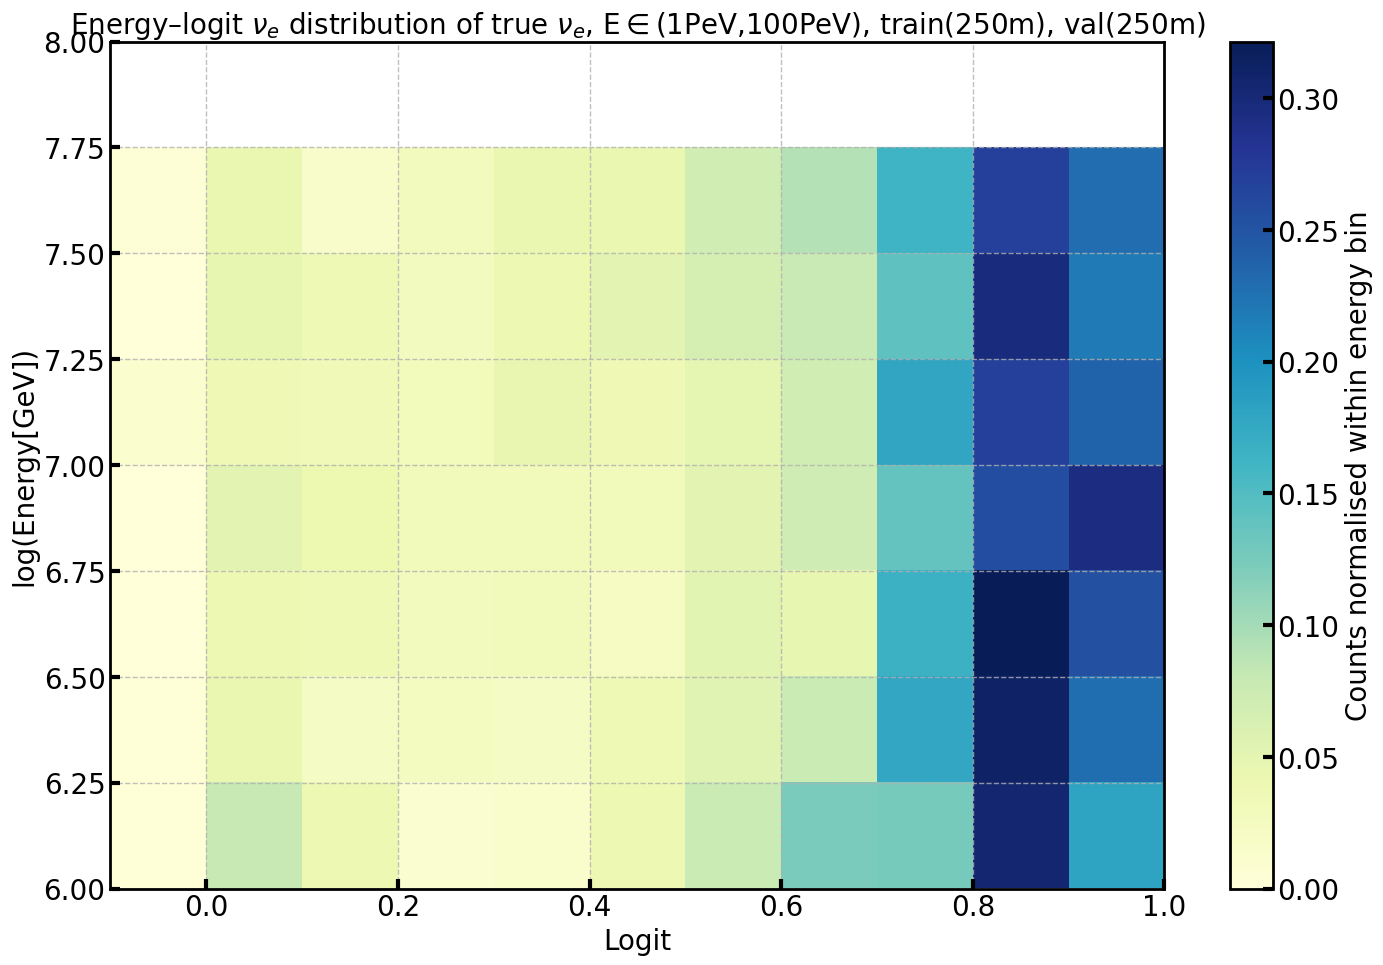

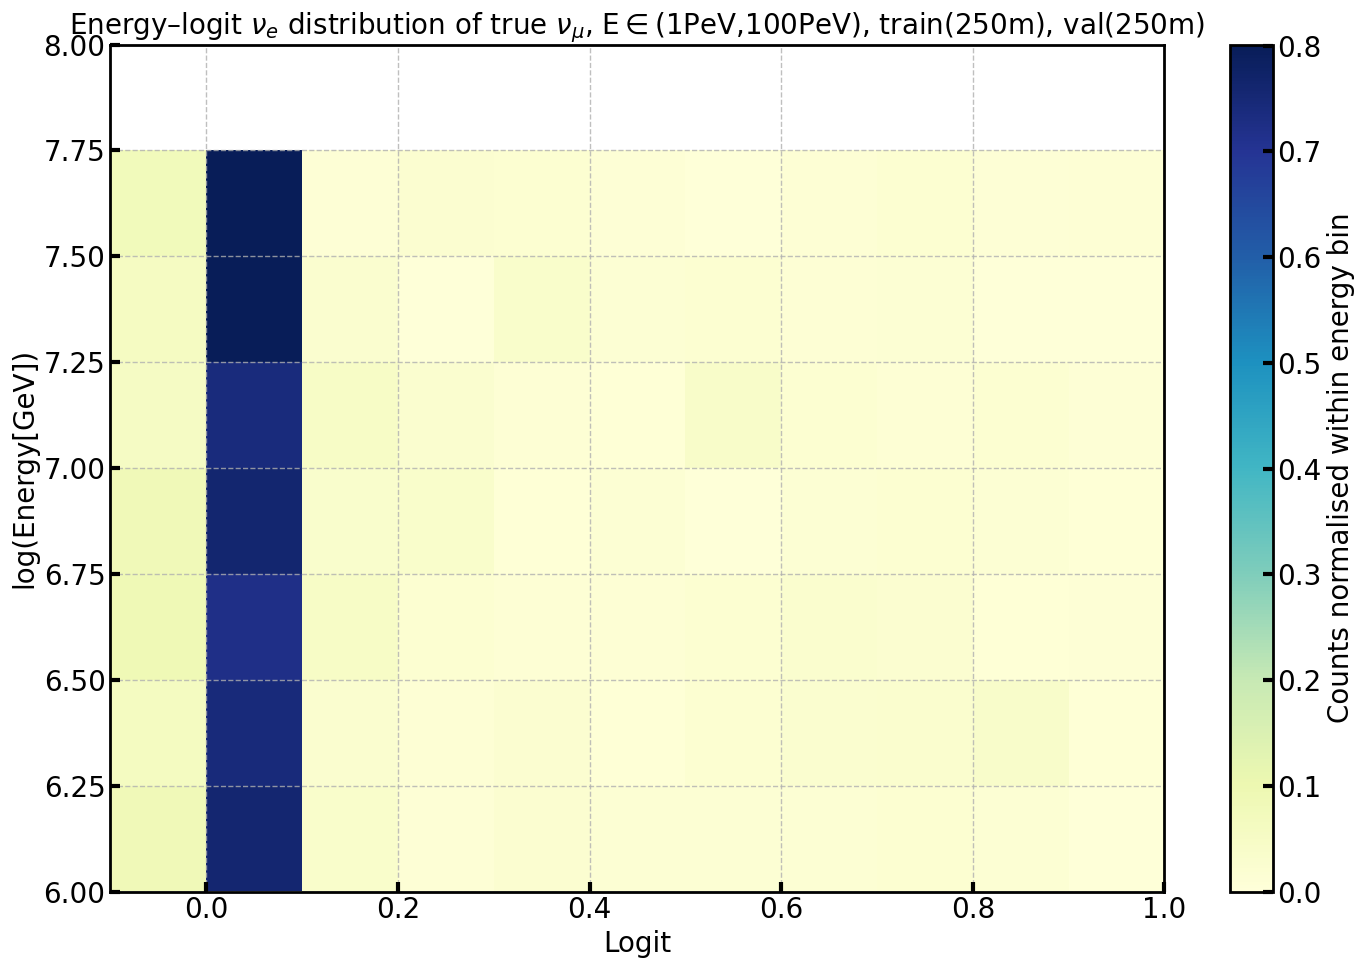

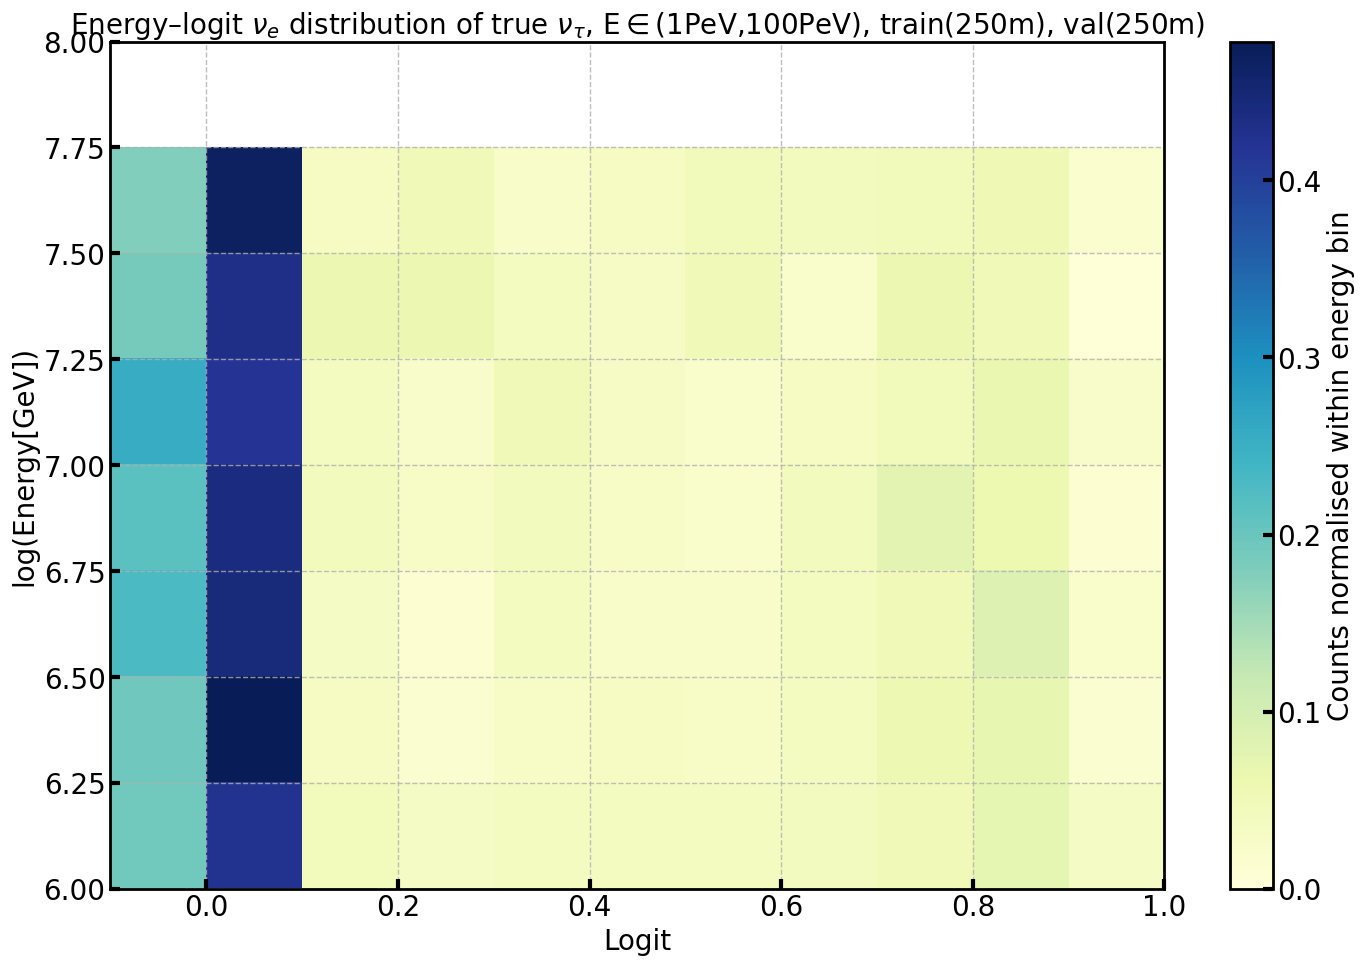

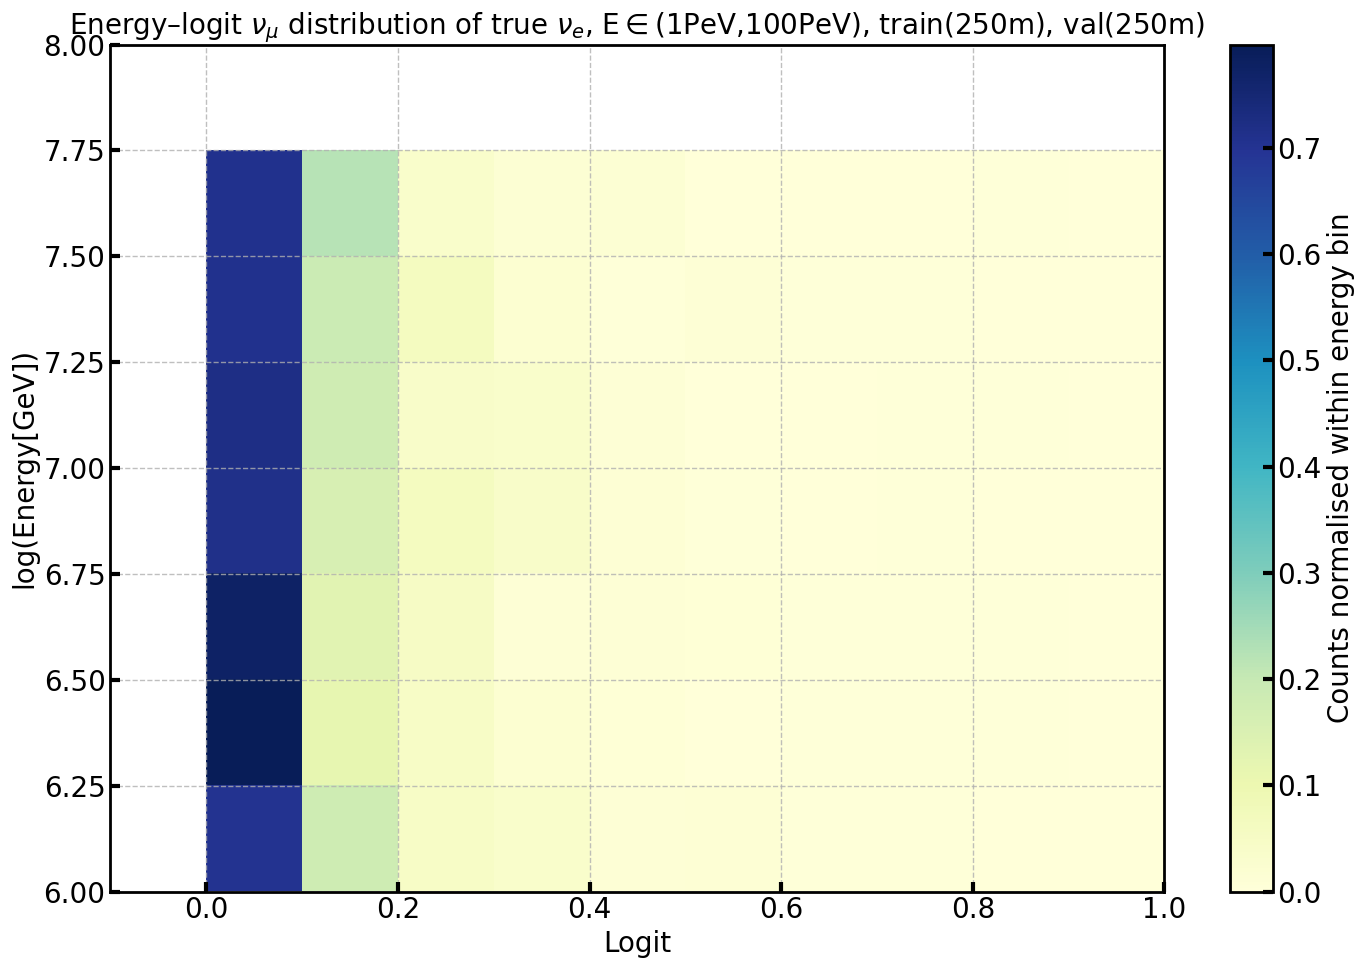

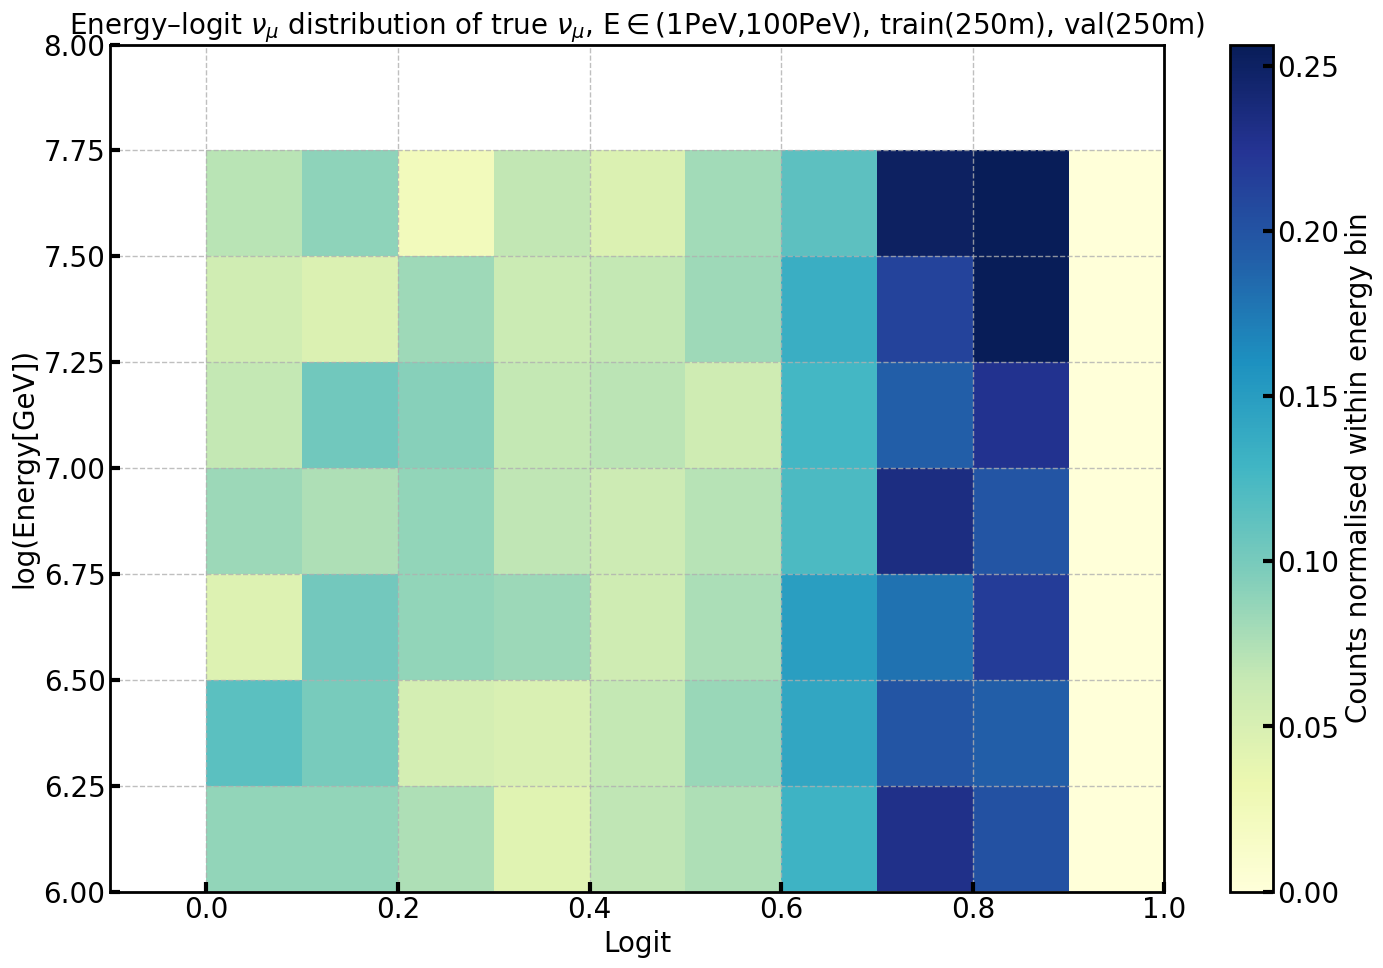

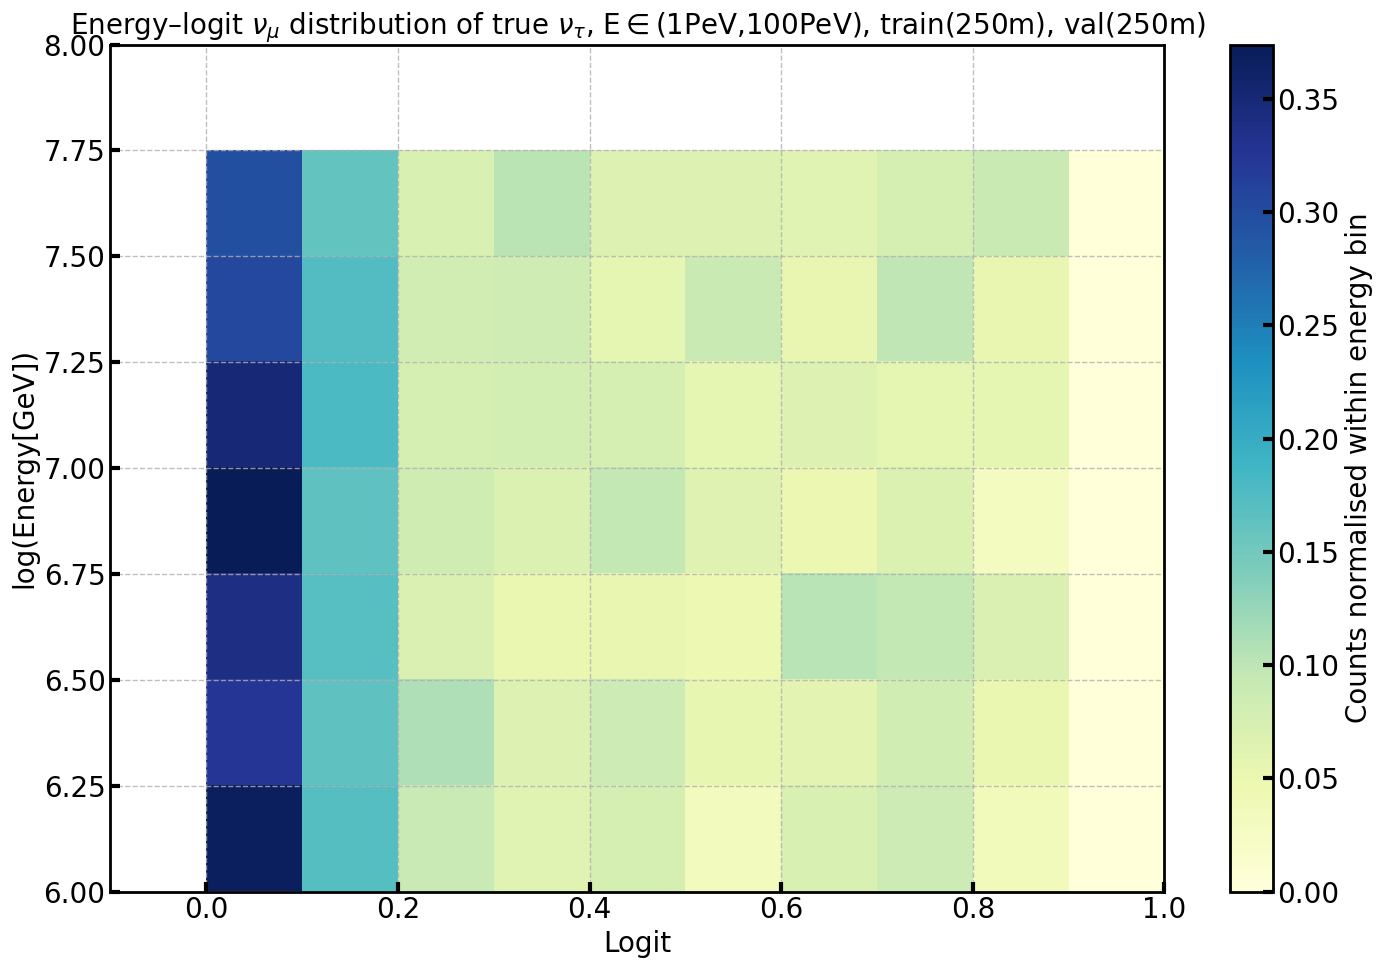

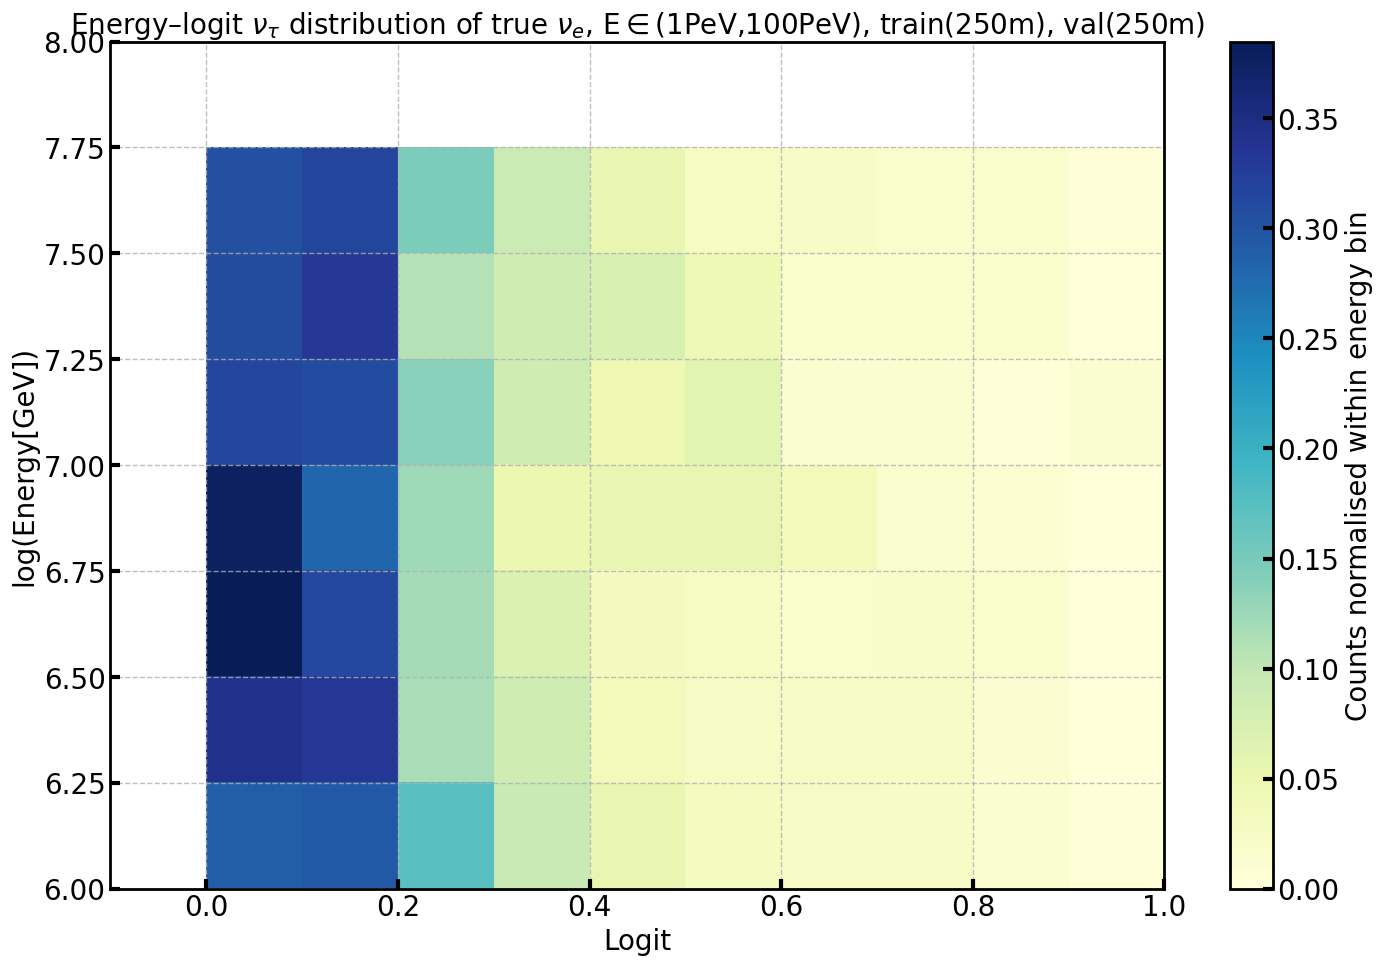

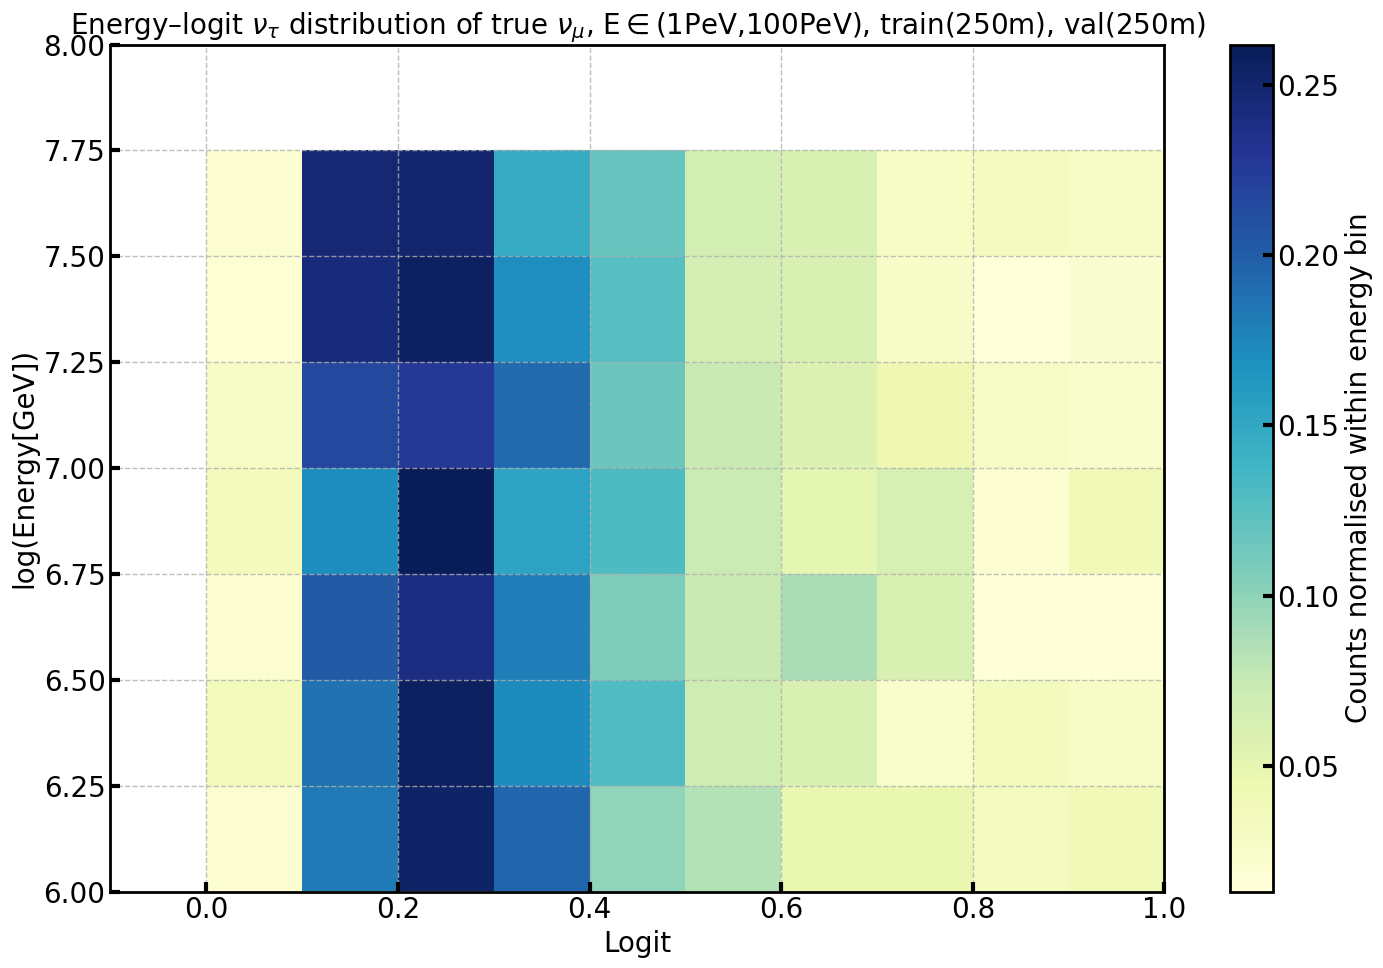

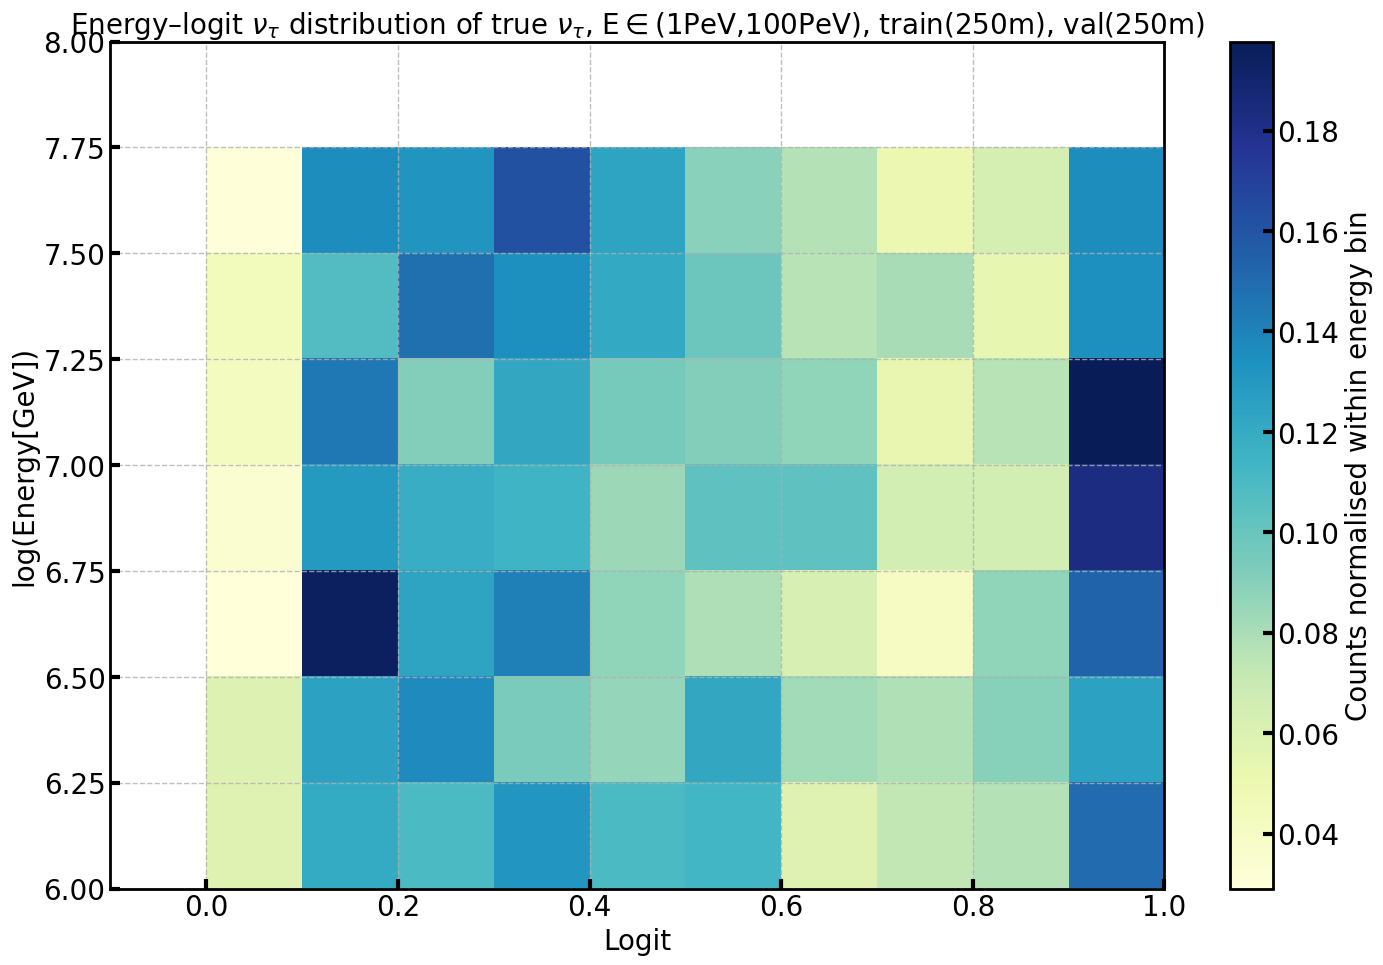

In [223]:
plot_csvs_energy(csvs_high, EnergyRange.ER_1_PEV_100_PEV)

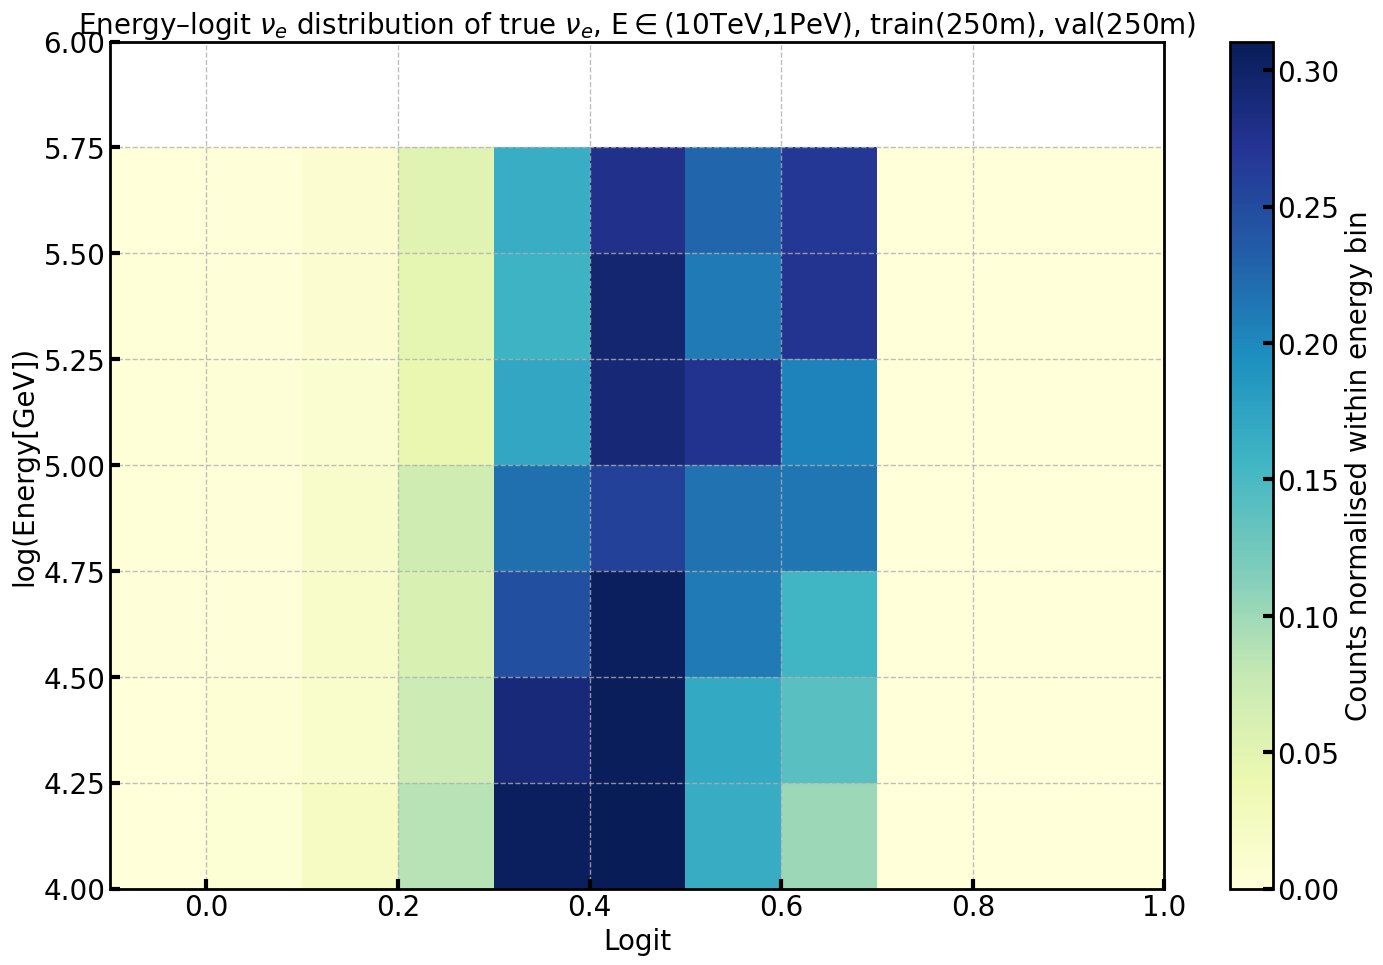

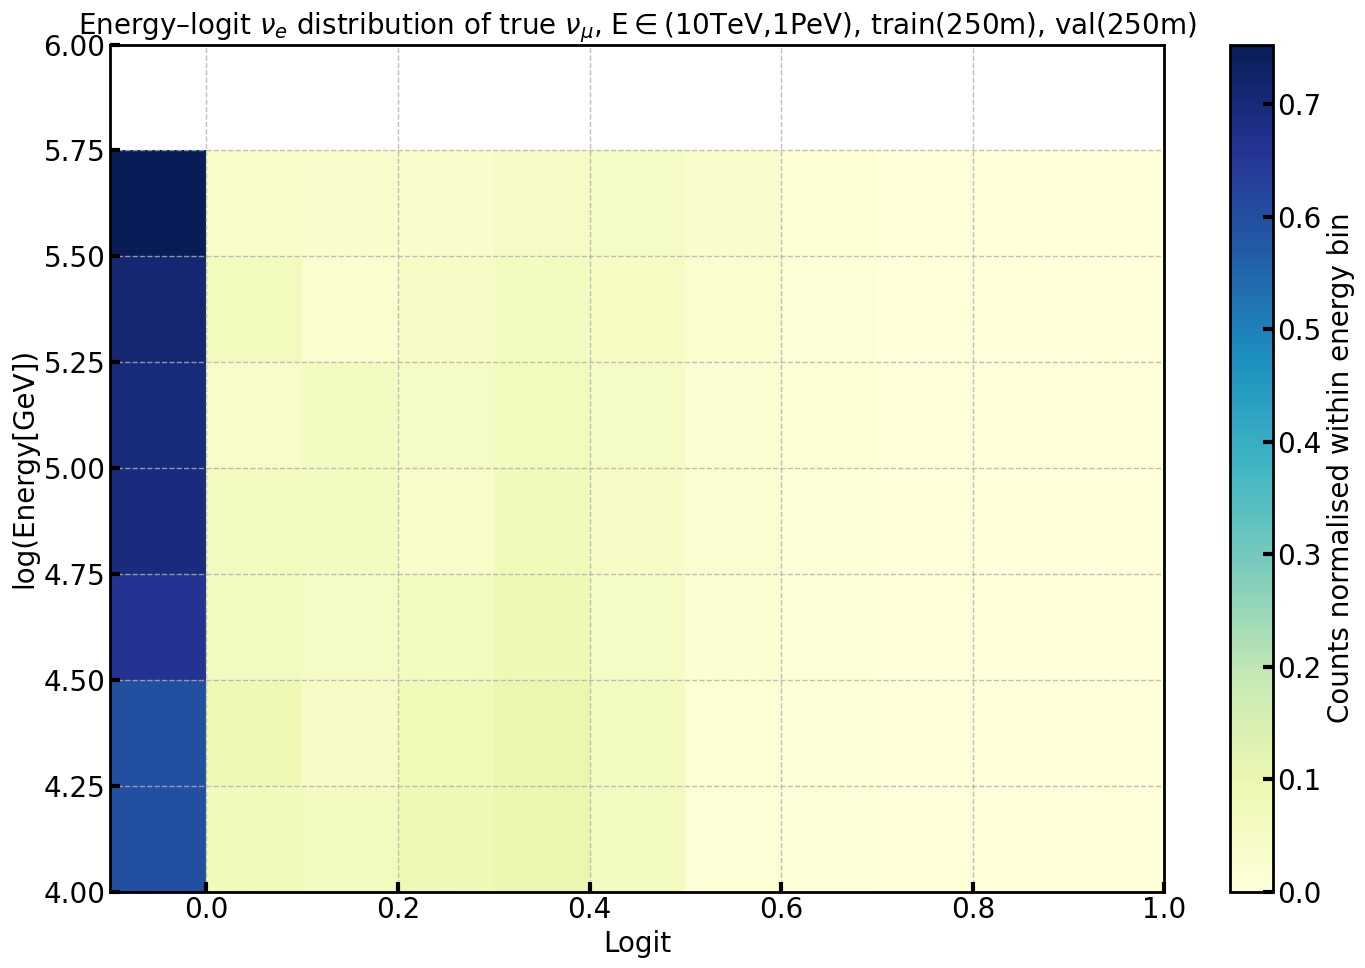

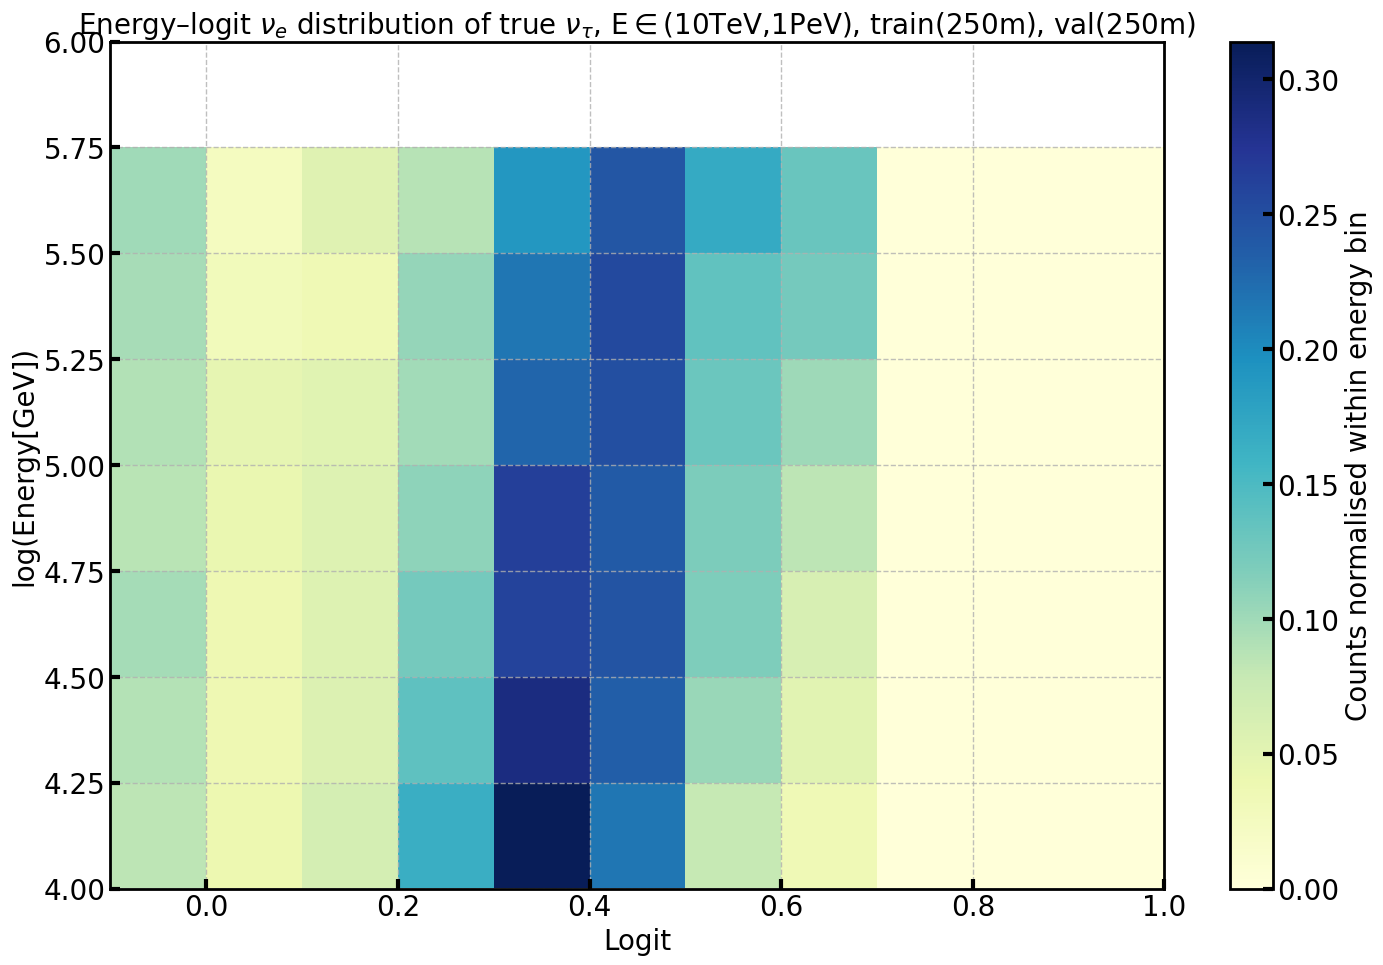

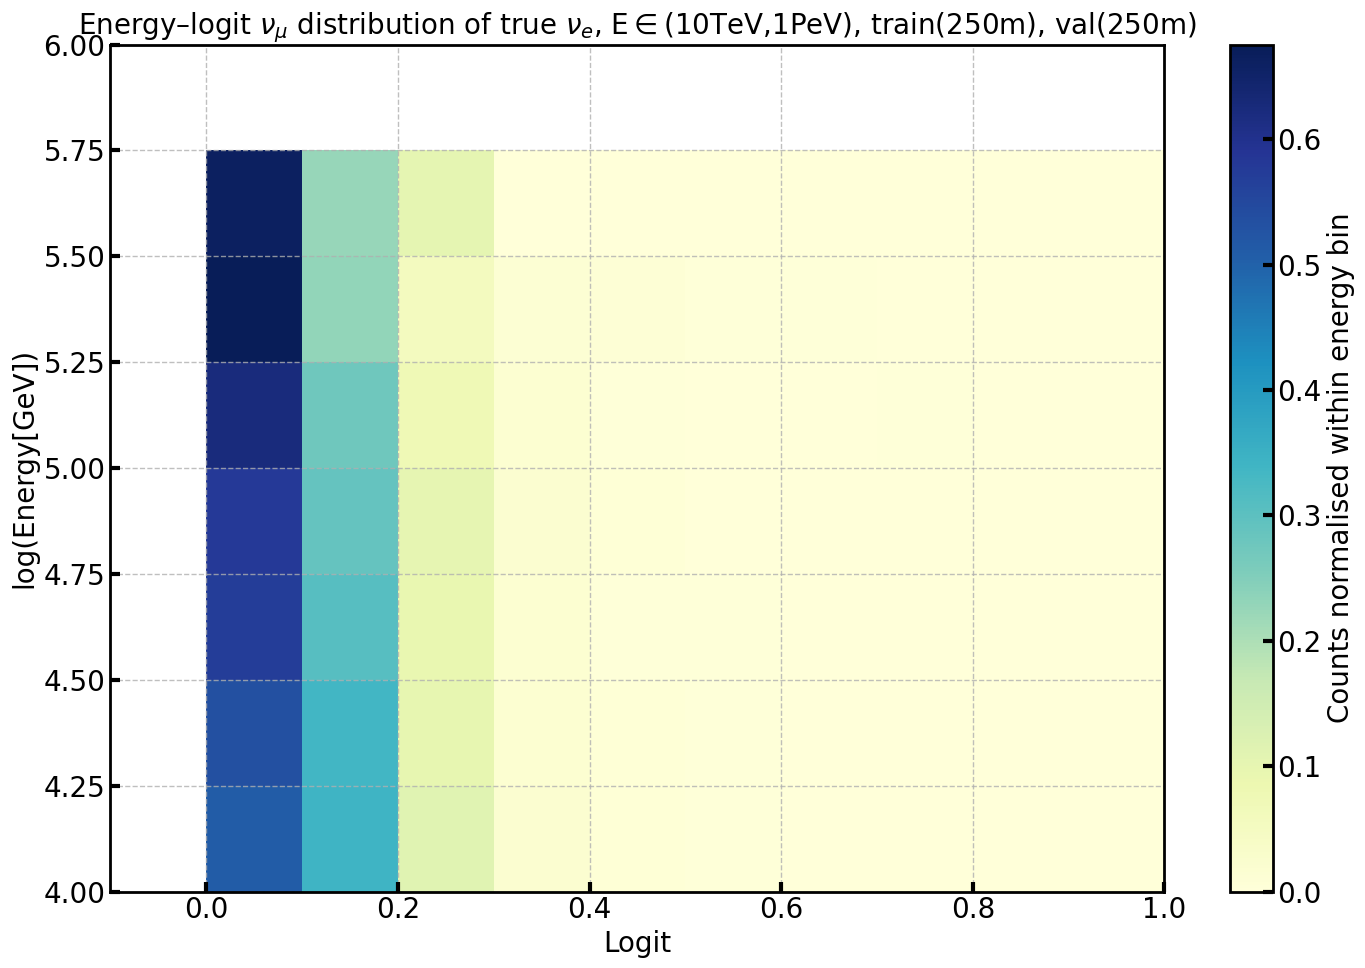

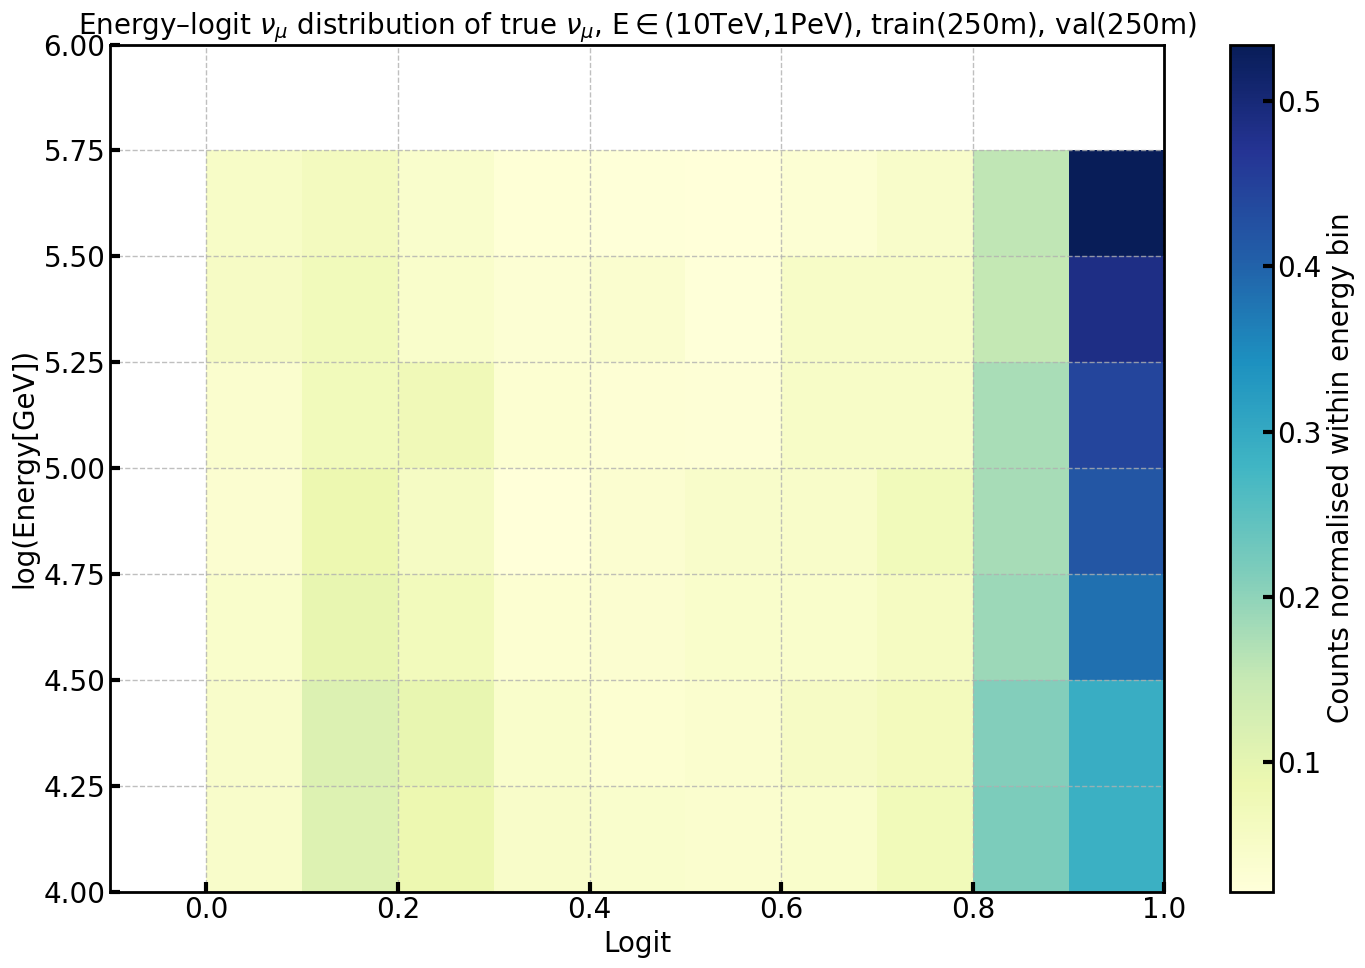

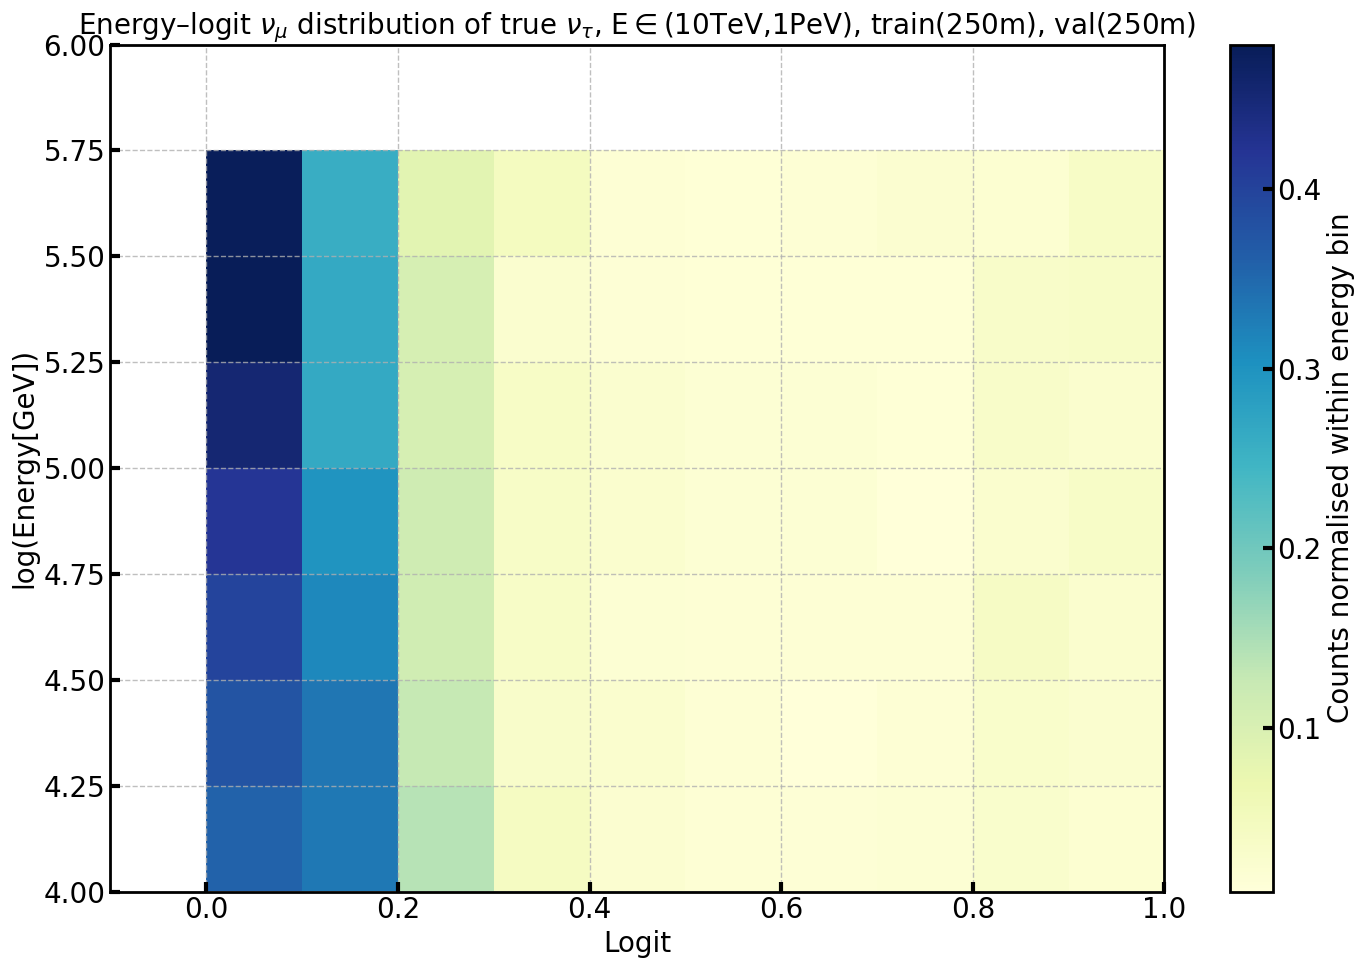

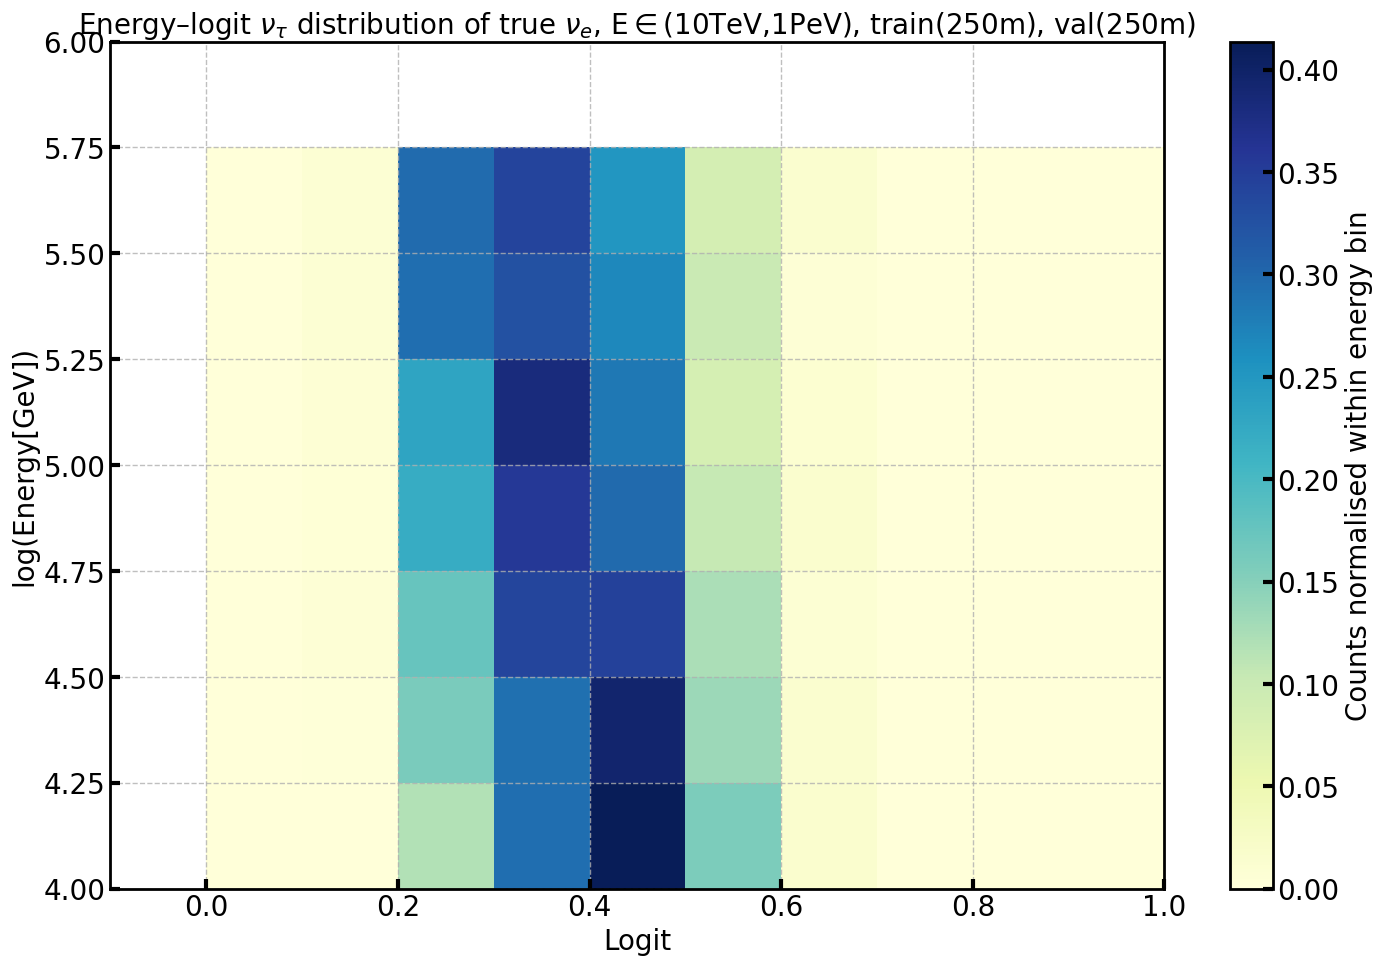

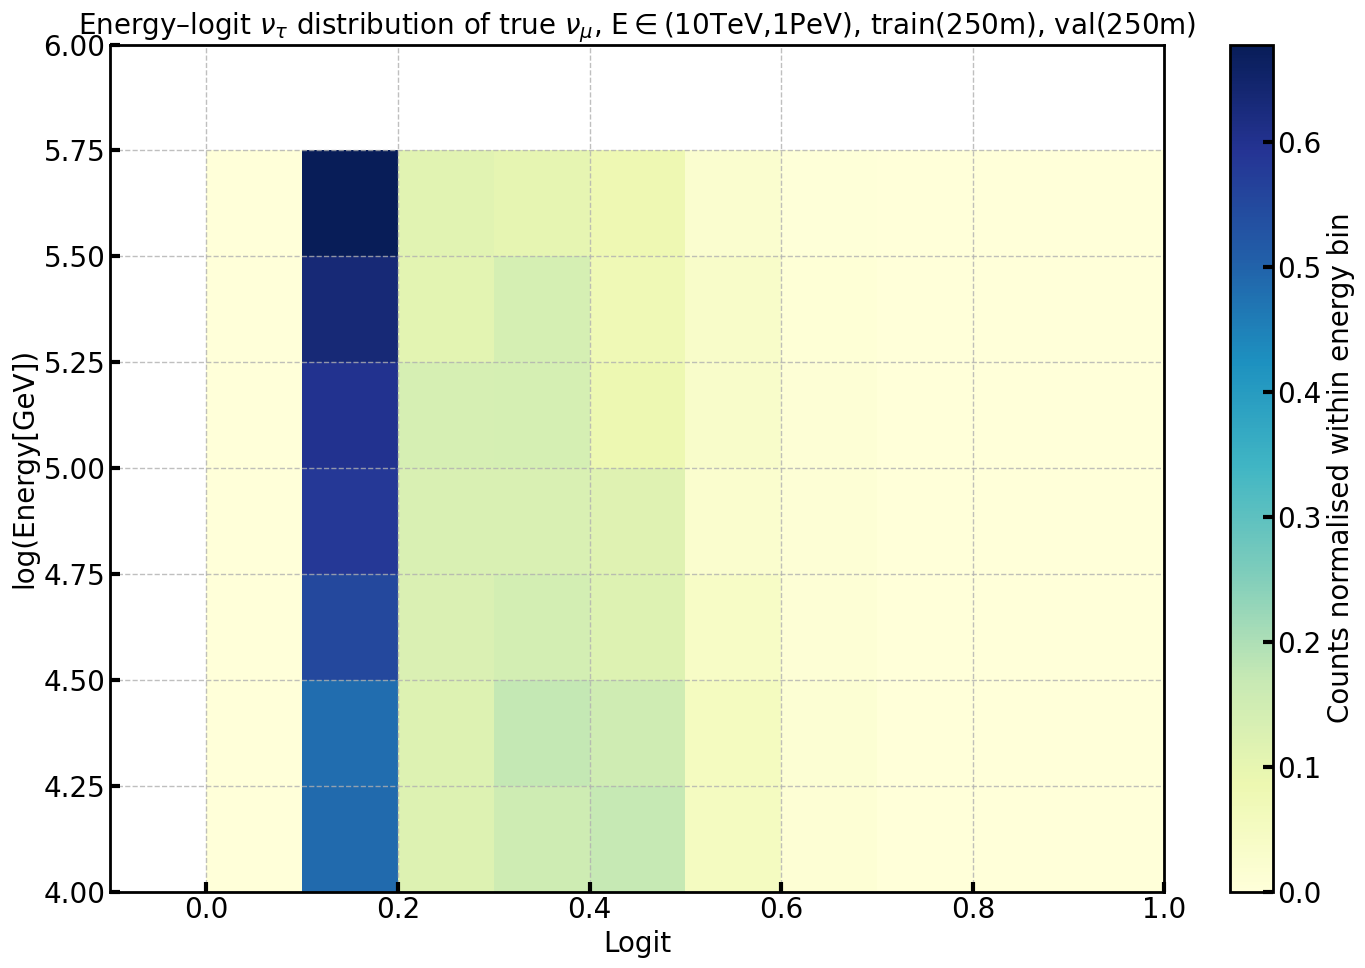

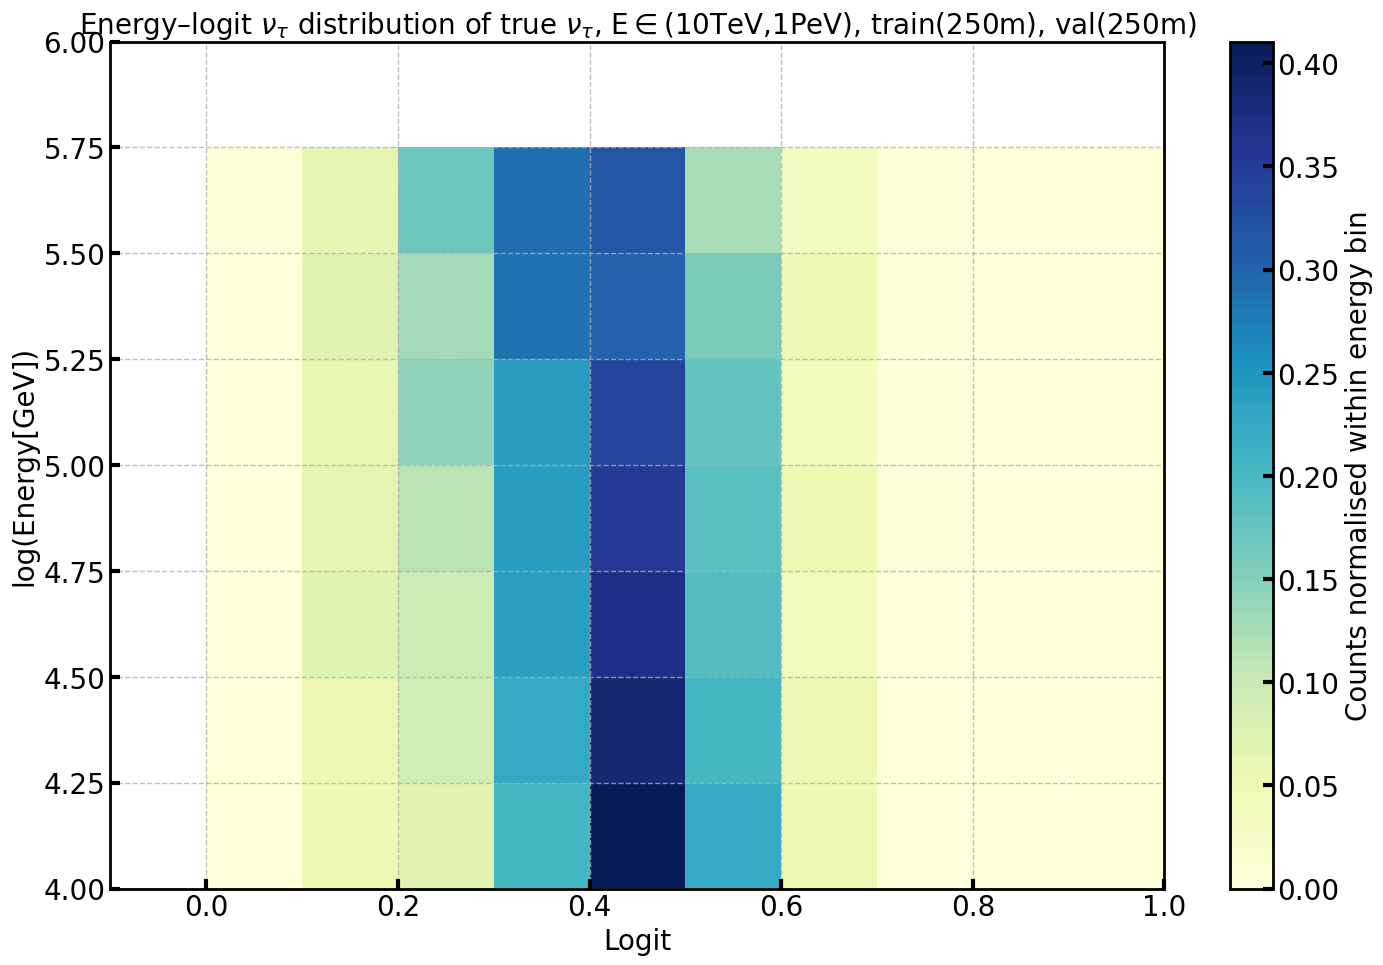

In [224]:
plot_csvs_energy(csvs_medium, EnergyRange.ER_10_TEV_1_PEV)

In [225]:
def plot_zenith_logit_distribution_mono_flavour(nu_logit : np.ndarray,
                                                nu_zenith: np.ndarray,
                                                logit_flavour: Flavour,
                                                flavour: Flavour, 
                                                id: str) -> None:
    Nbins, binwidth, bins, counts, bin_centers = getHistoParam(nu_logit, binwidth=0.1)
    zenith_binwidth = 22.5
    zenith_bin = np.arange(0, 180+zenith_binwidth, zenith_binwidth)

    H, xedges, yedges = np.histogram2d(nu_logit, nu_zenith, bins=[bins, zenith_bin])
    H = H / (H.sum(axis=0, keepdims=True) + 1e-8)  # prevent div-by-zero

    fig, ax = plt.subplots(figsize=(17, 11))
    mesh = ax.pcolormesh(xedges, yedges, H.T, cmap='YlOrBr', shading='auto')

    fig.colorbar(mesh, ax=ax, label="Counts normalised within zenith bin")
    ax.set_title(fr"Zenith–logit ${logit_flavour.latex}$ distribution of true ${flavour.latex}$, {id}")
    ax.set_xlabel('Logit')
    ax.set_ylabel('Zenith [degree]')
    ax.set_xlim(-0.1, 1.0)

In [226]:
def plot_zenith_logit_distribution(df: pd.DataFrame, 
                                   flavour: Flavour,
                                   id: str) -> None:
    nu_e_logit, nu_mu_logit, nu_tau_logit = get_nu_logits(df, flavour)
    e_zenith, mu_zenith, tau_zenith = get_zenith(df, flavour)
    
    plot_zenith_logit_distribution_mono_flavour(nu_e_logit, e_zenith, flavour, Flavour.E, id)
    plot_zenith_logit_distribution_mono_flavour(nu_mu_logit, mu_zenith, flavour, Flavour.MU, id)
    plot_zenith_logit_distribution_mono_flavour(nu_tau_logit, tau_zenith, flavour, Flavour.TAU, id)

In [227]:
def plot_csvs_zenith(csvs:dict):
    for id, csv in csvs.items():
        df = pd.read_csv(csv)
        print(df['azimuth'].describe())
        plot_zenith_logit_distribution(df, Flavour.E, id)
        plot_zenith_logit_distribution(df, Flavour.MU, id)
        plot_zenith_logit_distribution(df, Flavour.TAU, id)

count    6000.000000
mean        3.146695
std         1.825934
min         0.000962
25%         1.574360
50%         3.107474
75%         4.767345
max         6.282863
Name: azimuth, dtype: float64


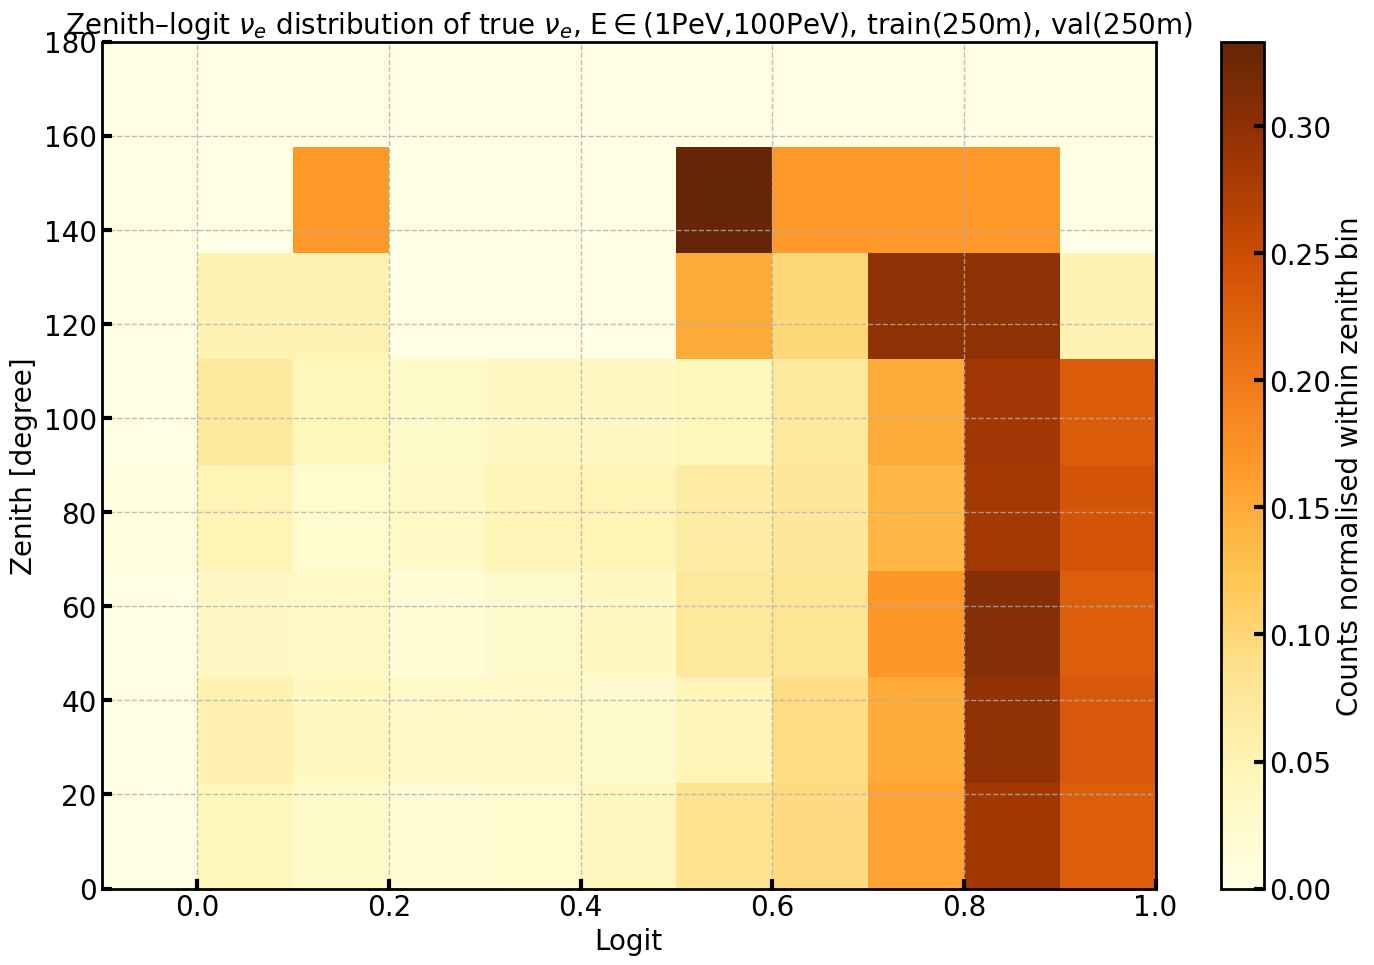

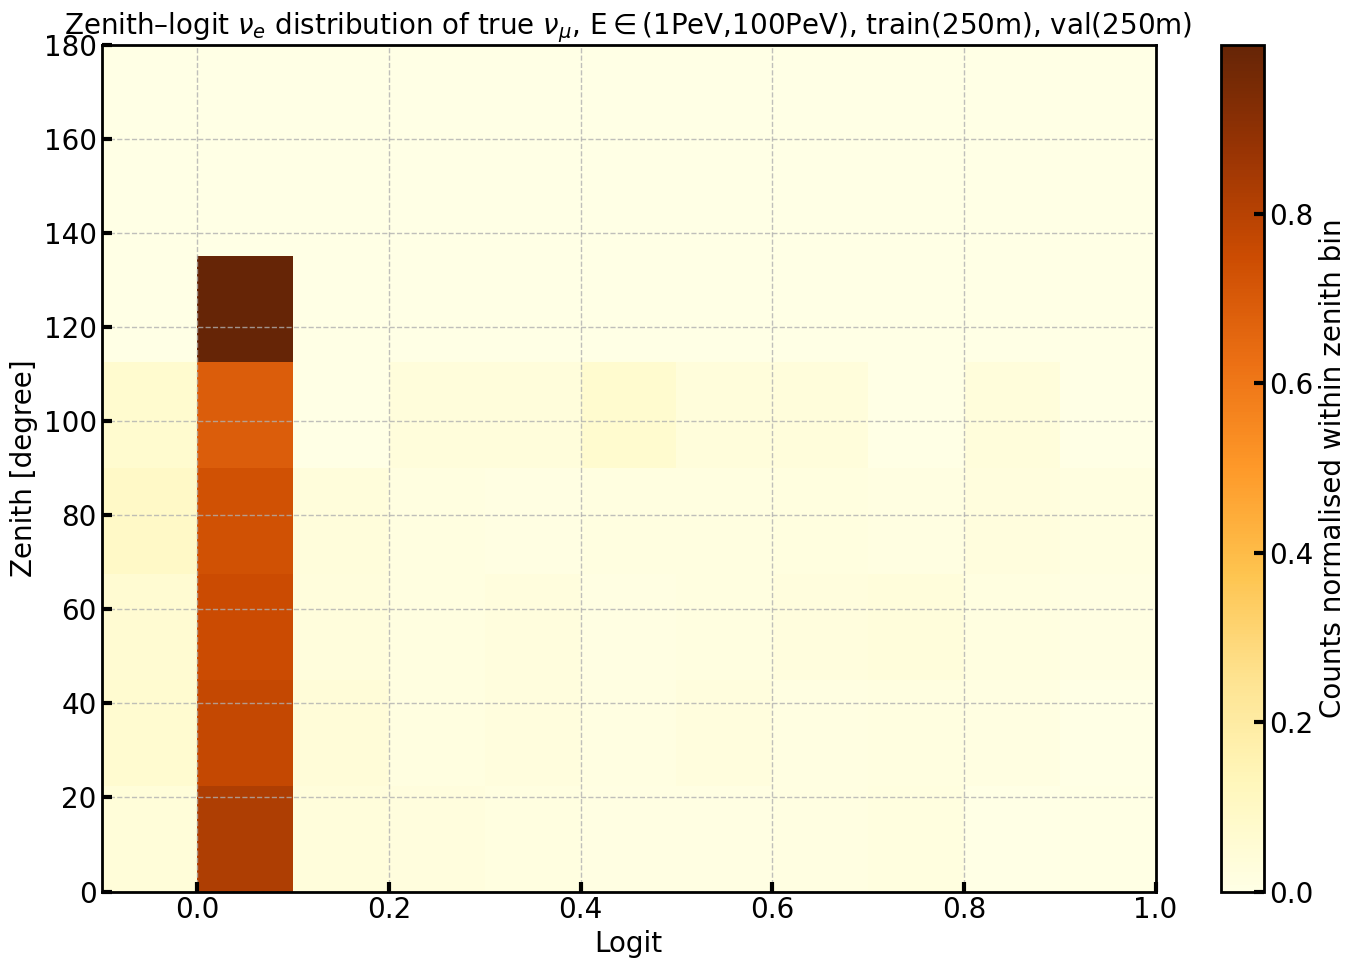

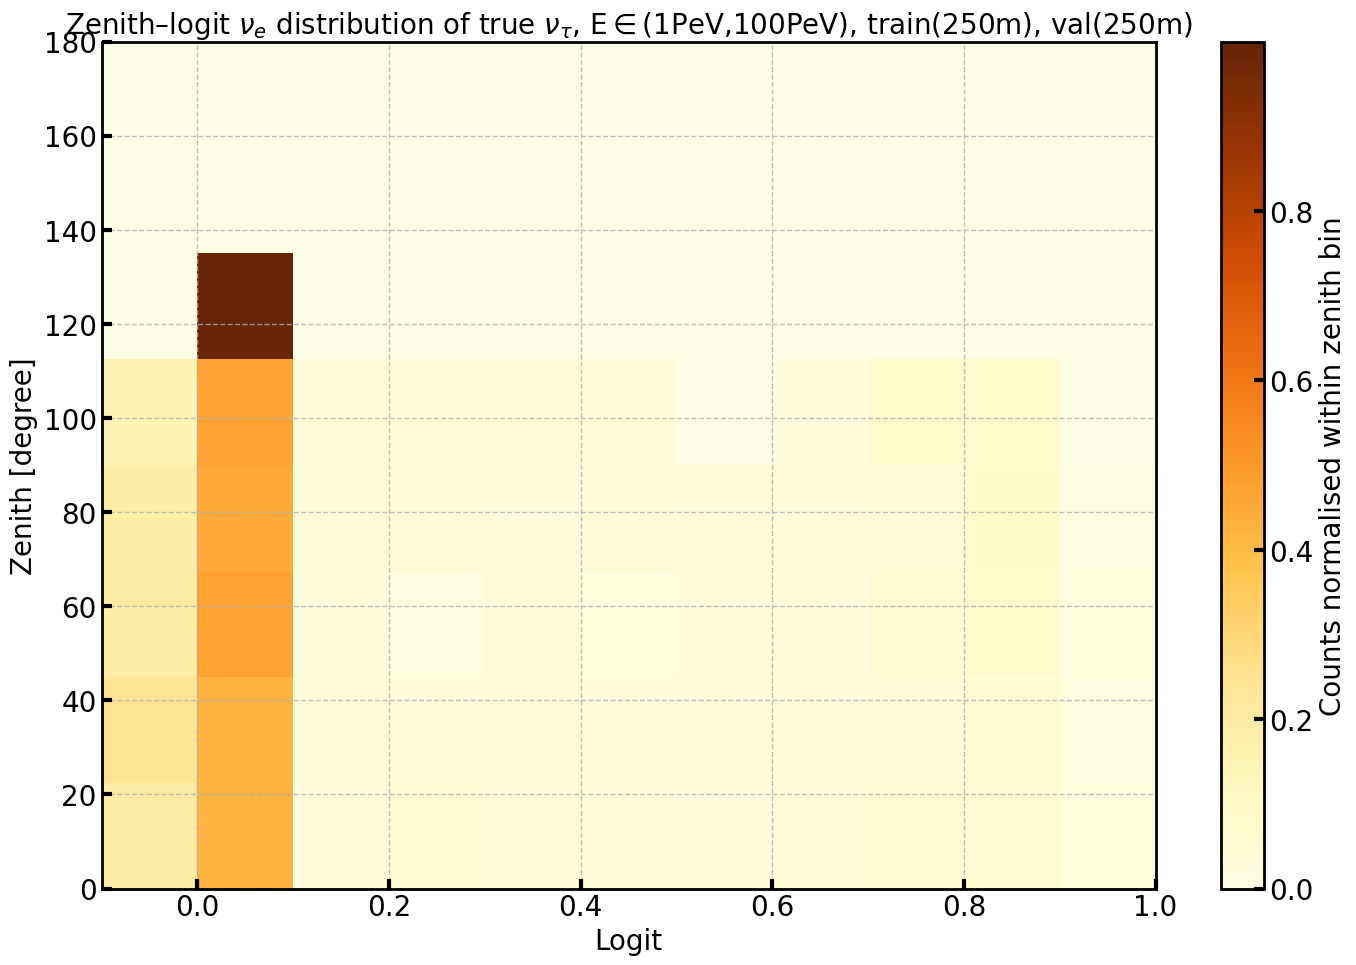

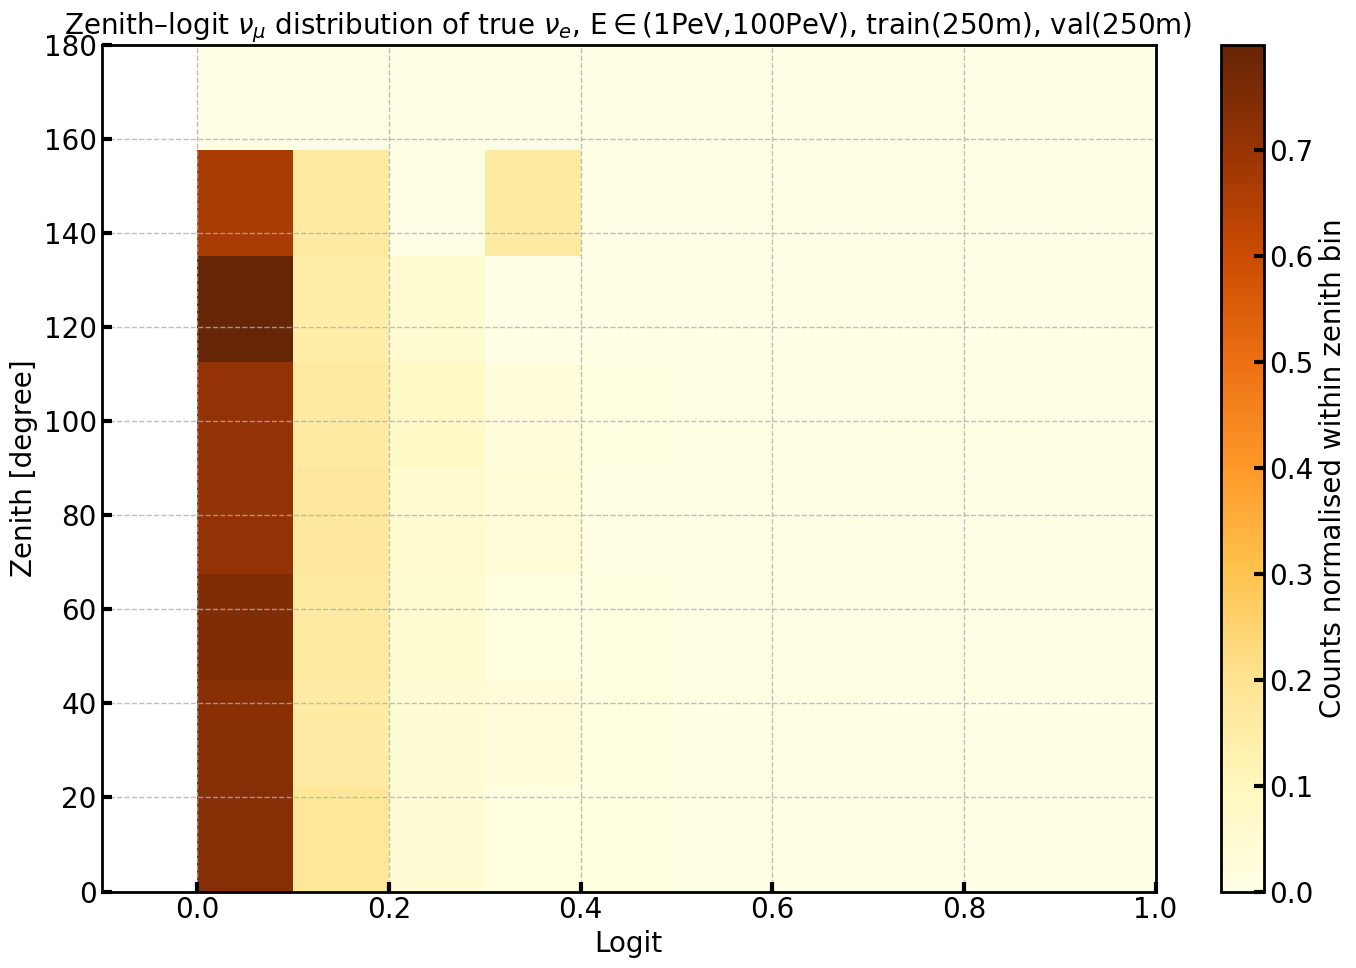

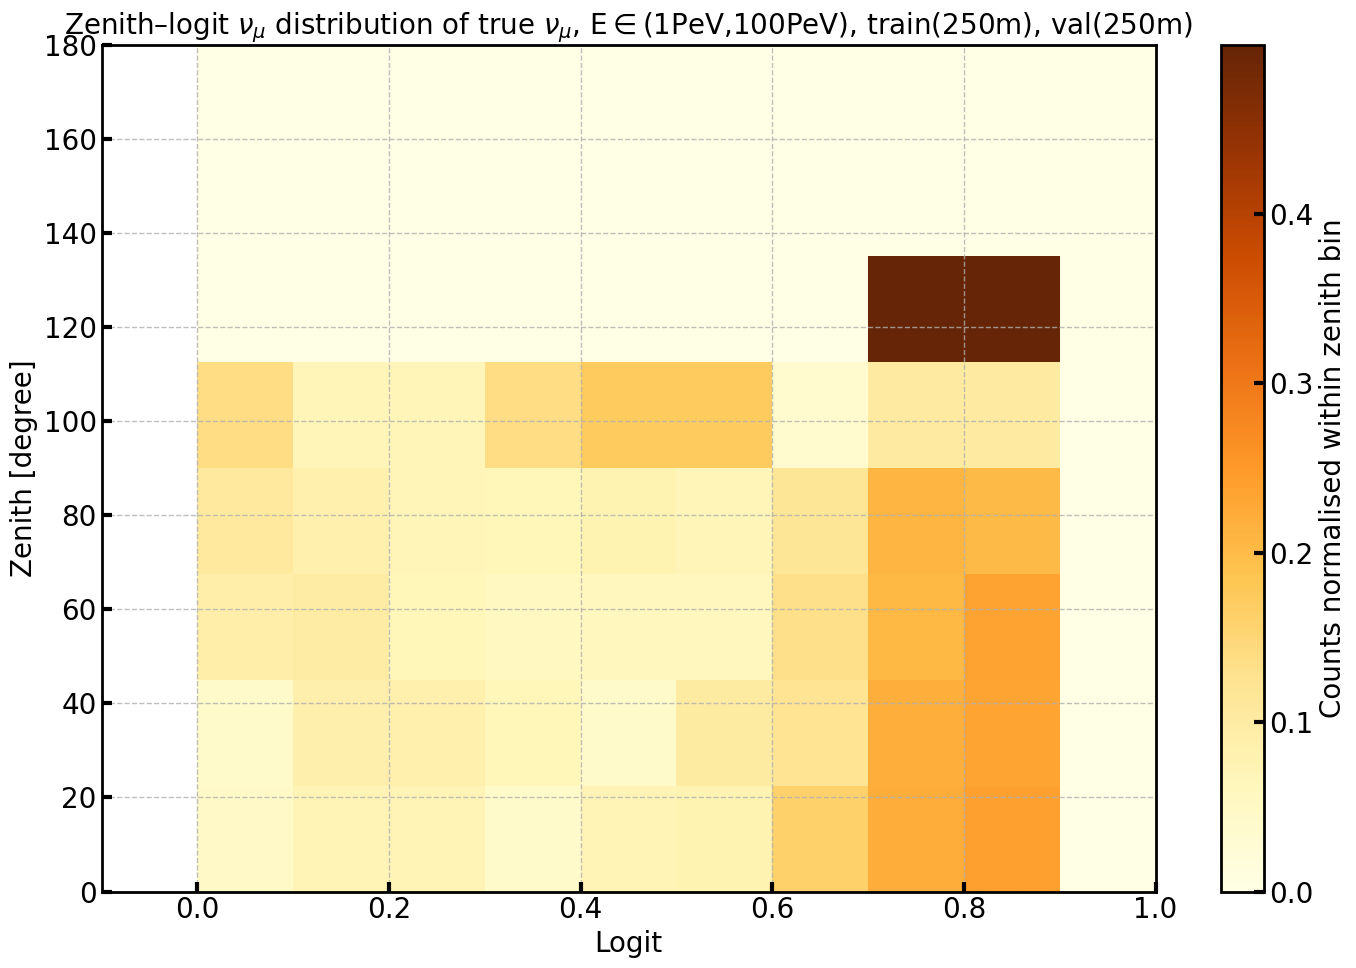

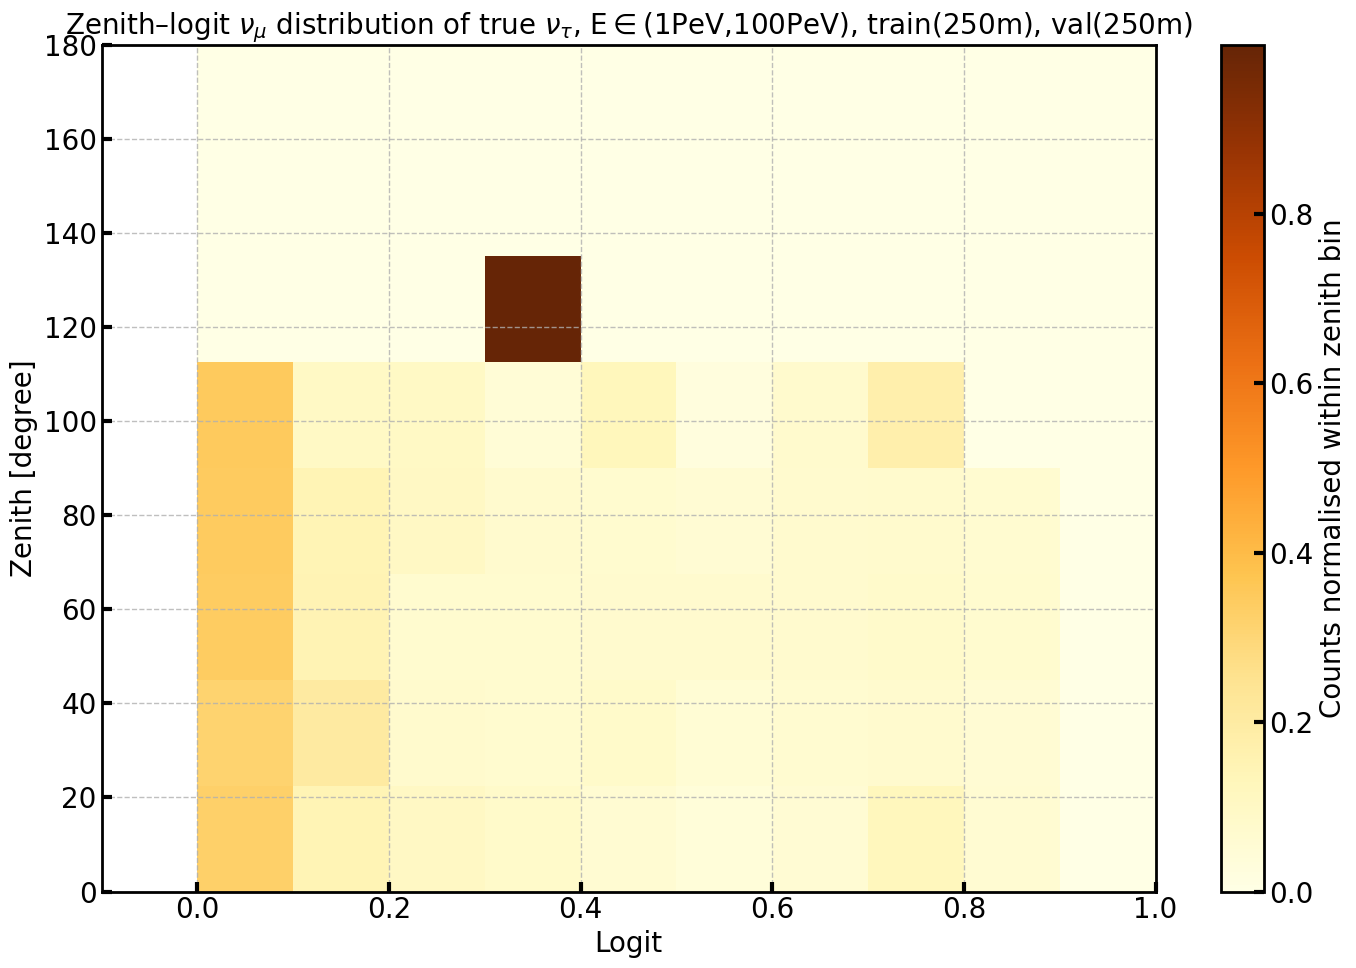

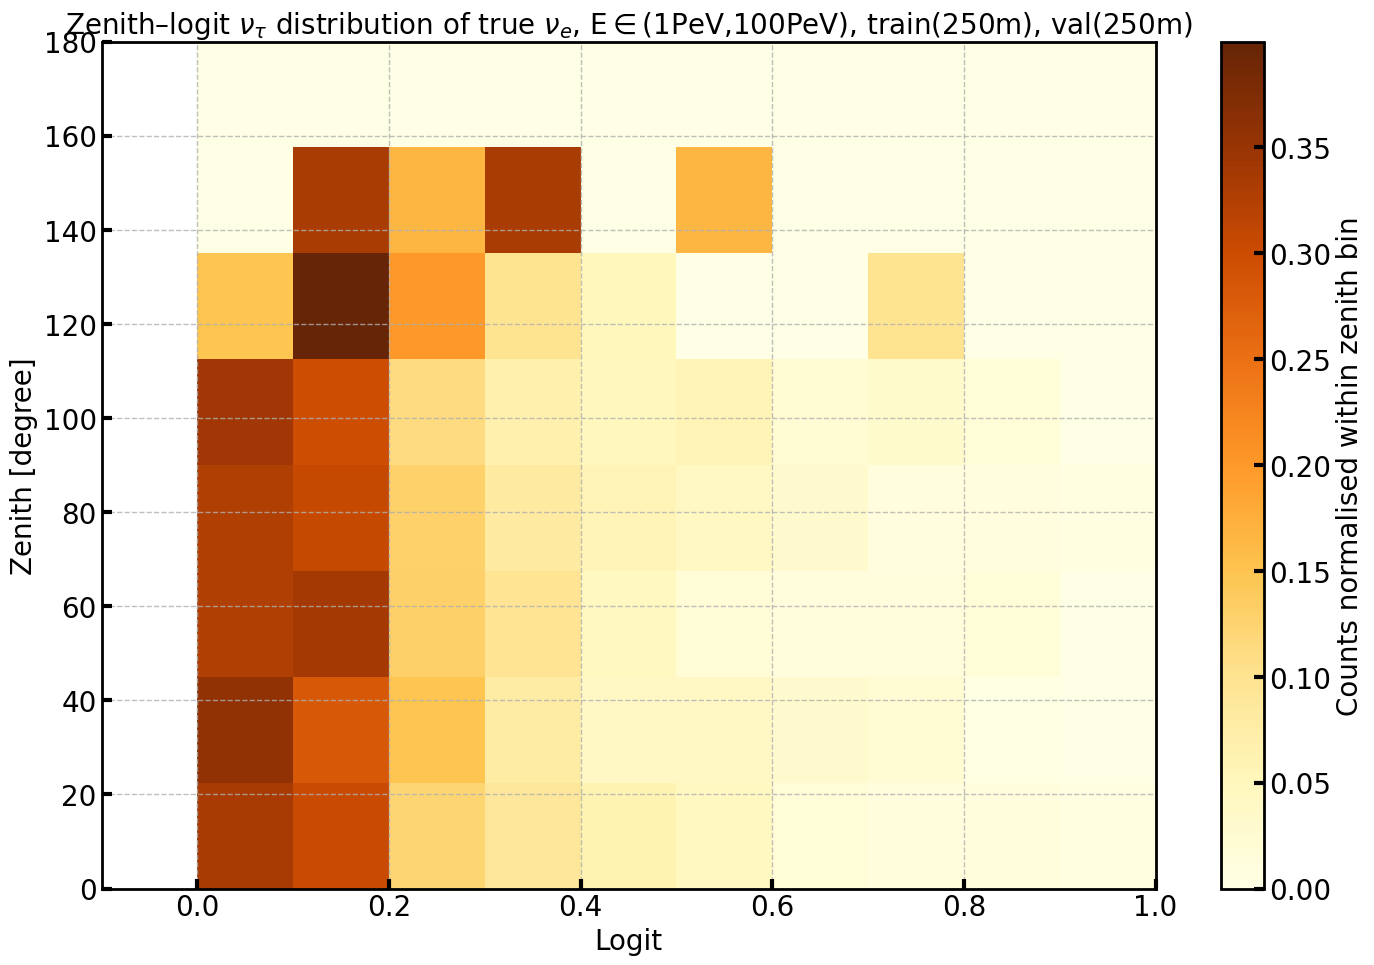

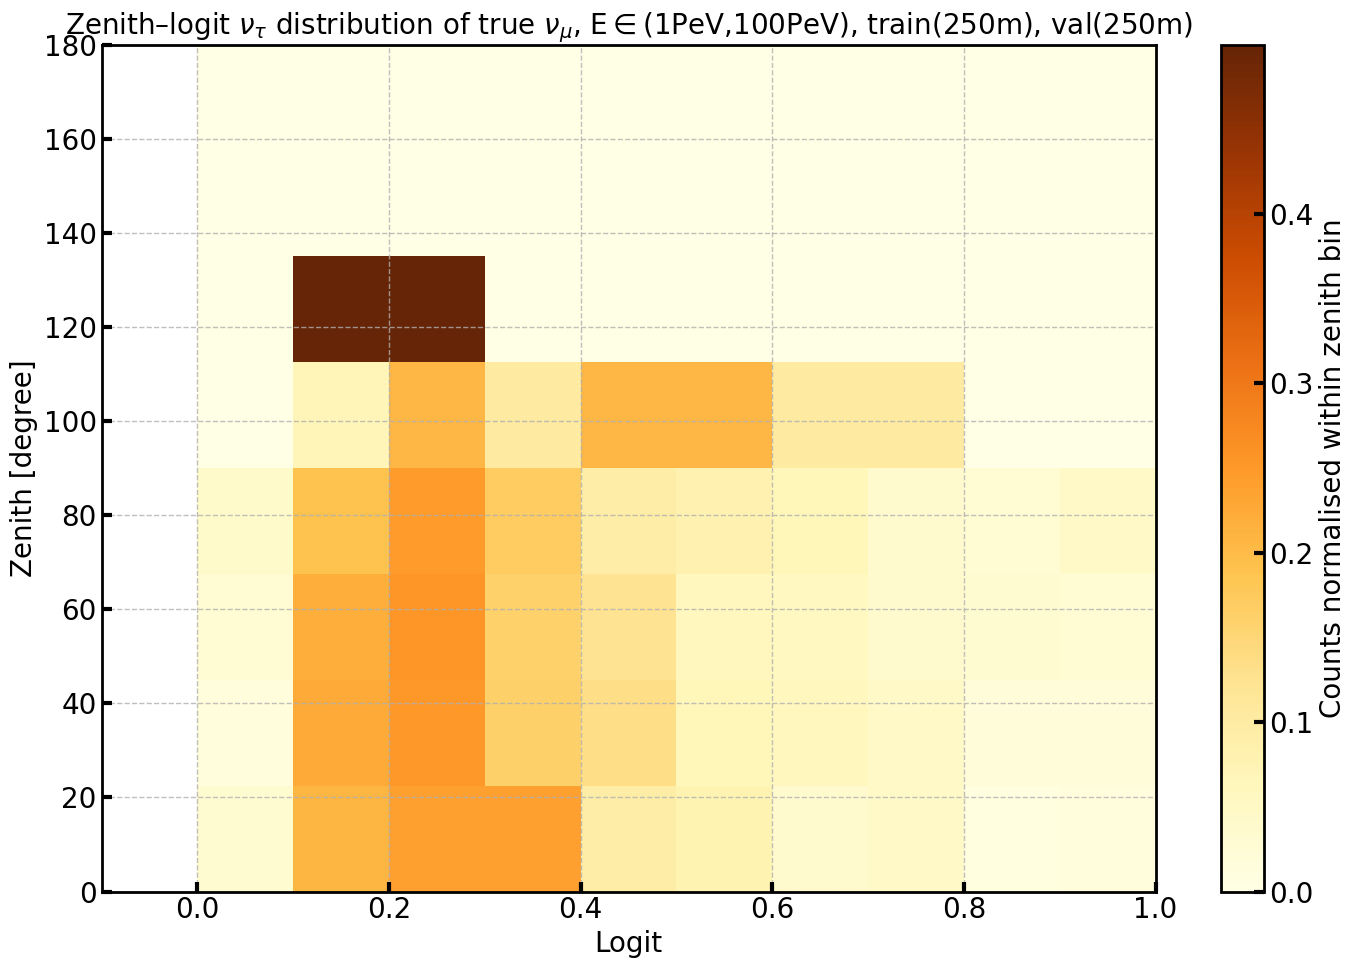

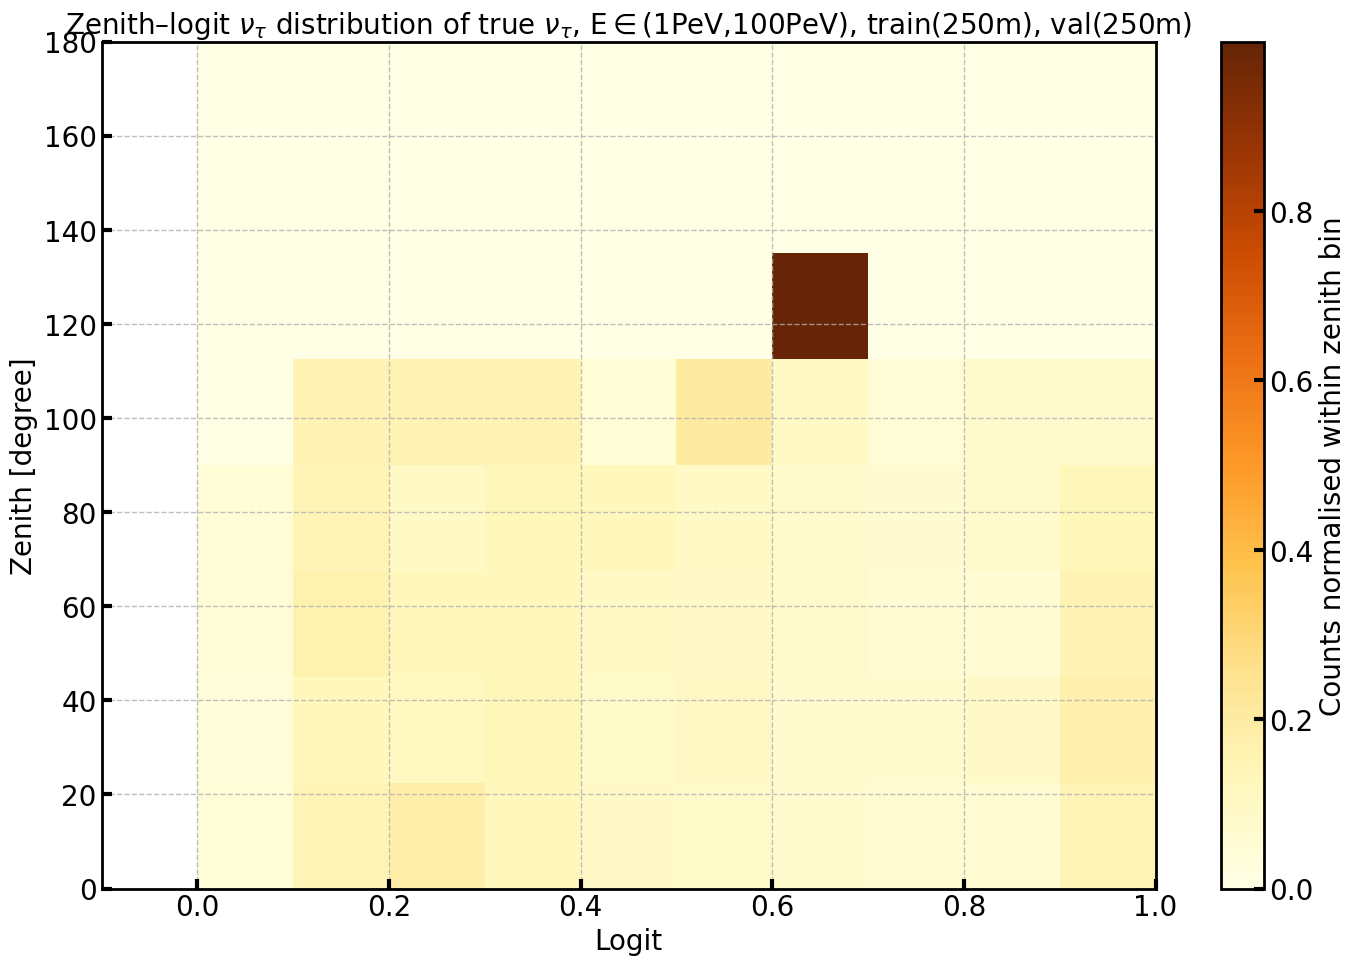

In [228]:
plot_csvs_zenith(csvs_high)

count    30000.000000
mean         3.150953
std          1.820027
min          0.000009
25%          1.568599
50%          3.136352
75%          4.740037
max          6.283097
Name: azimuth, dtype: float64


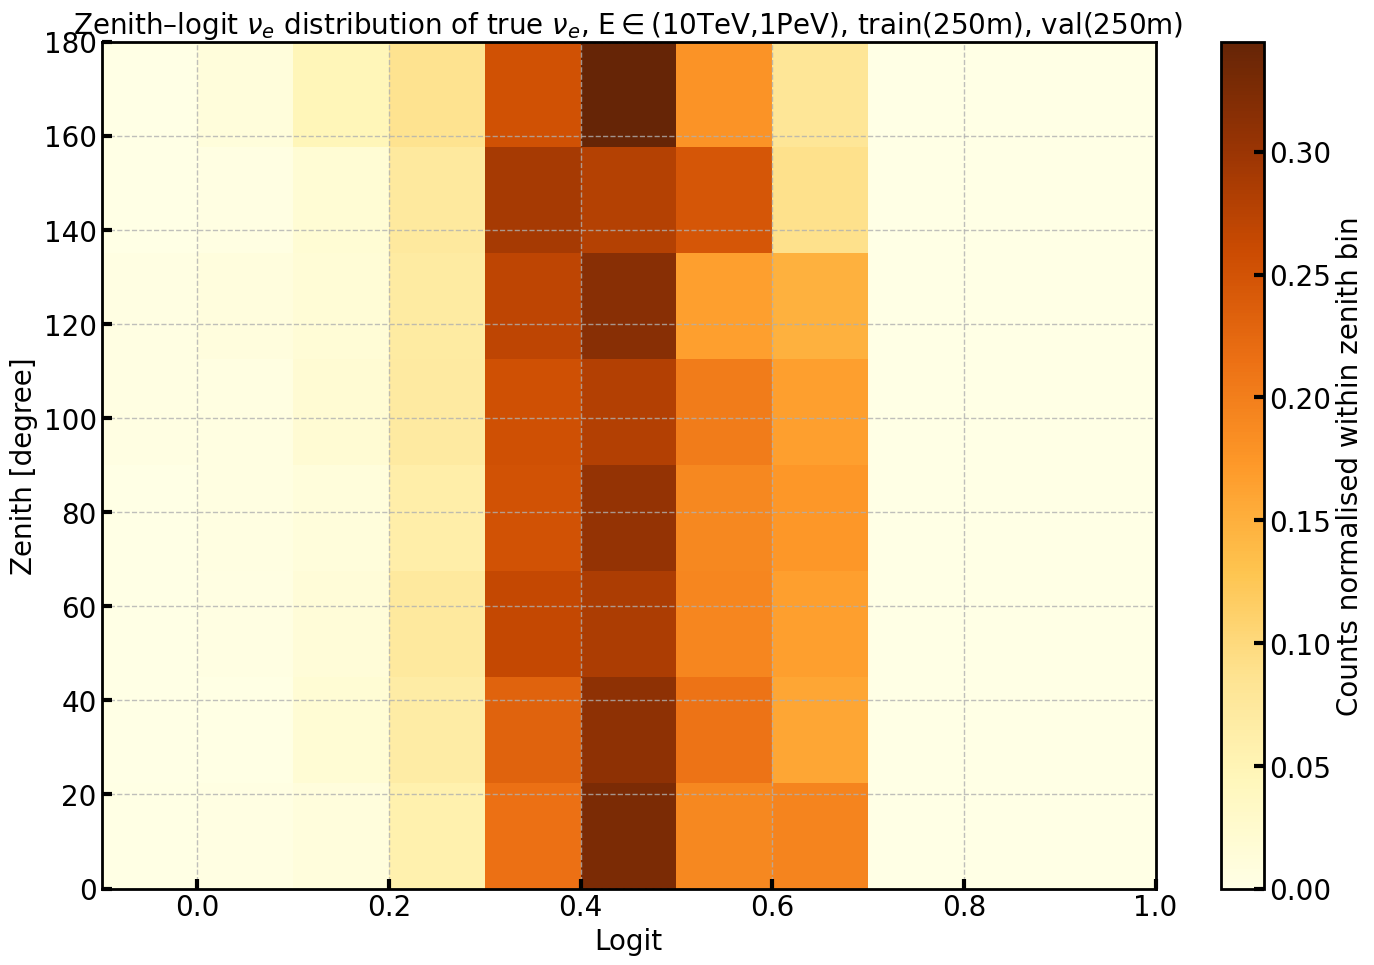

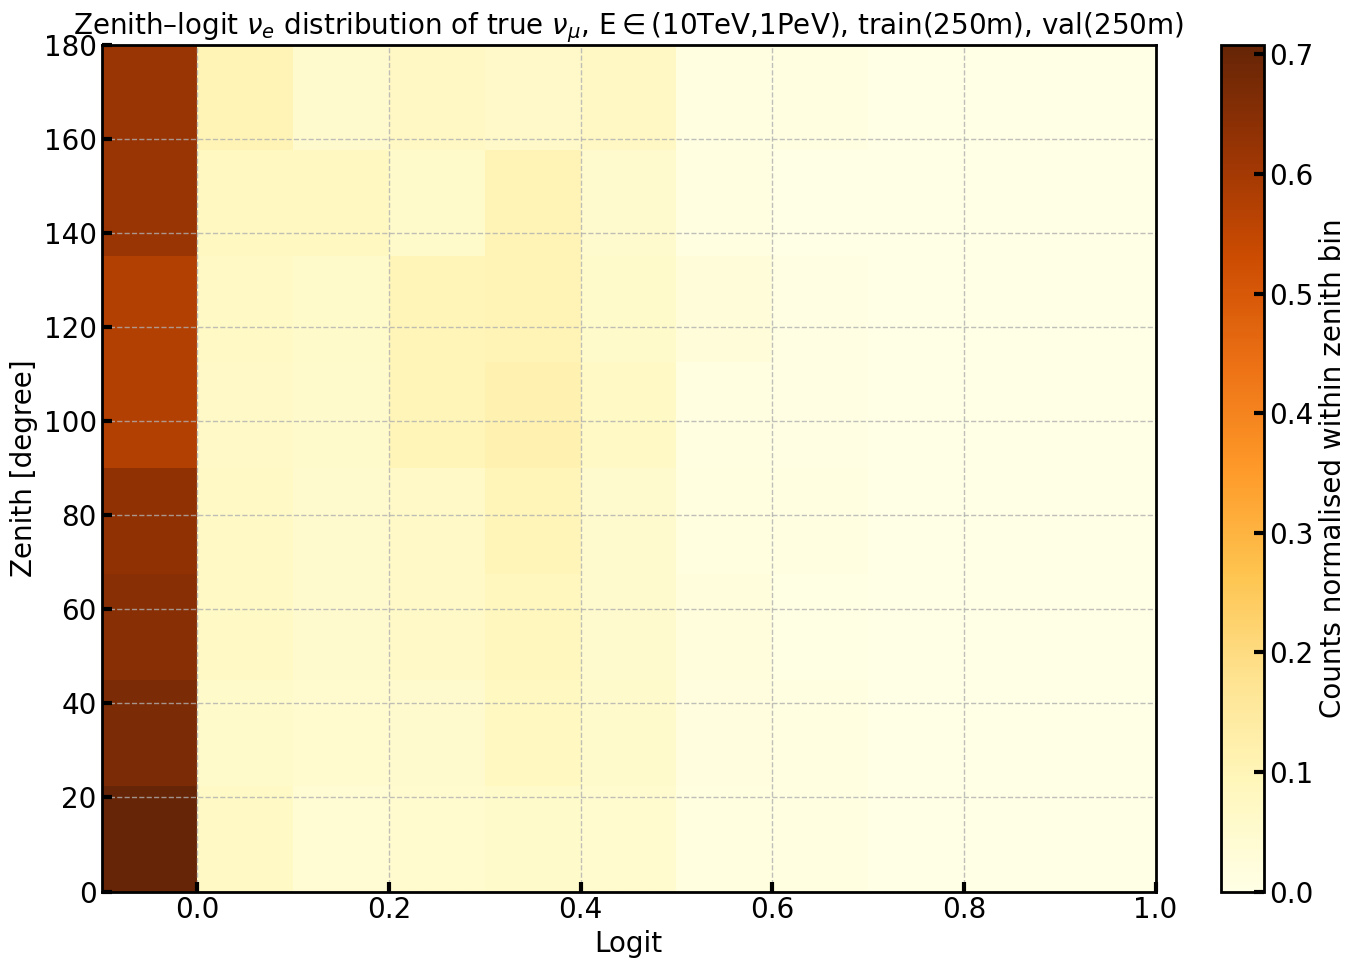

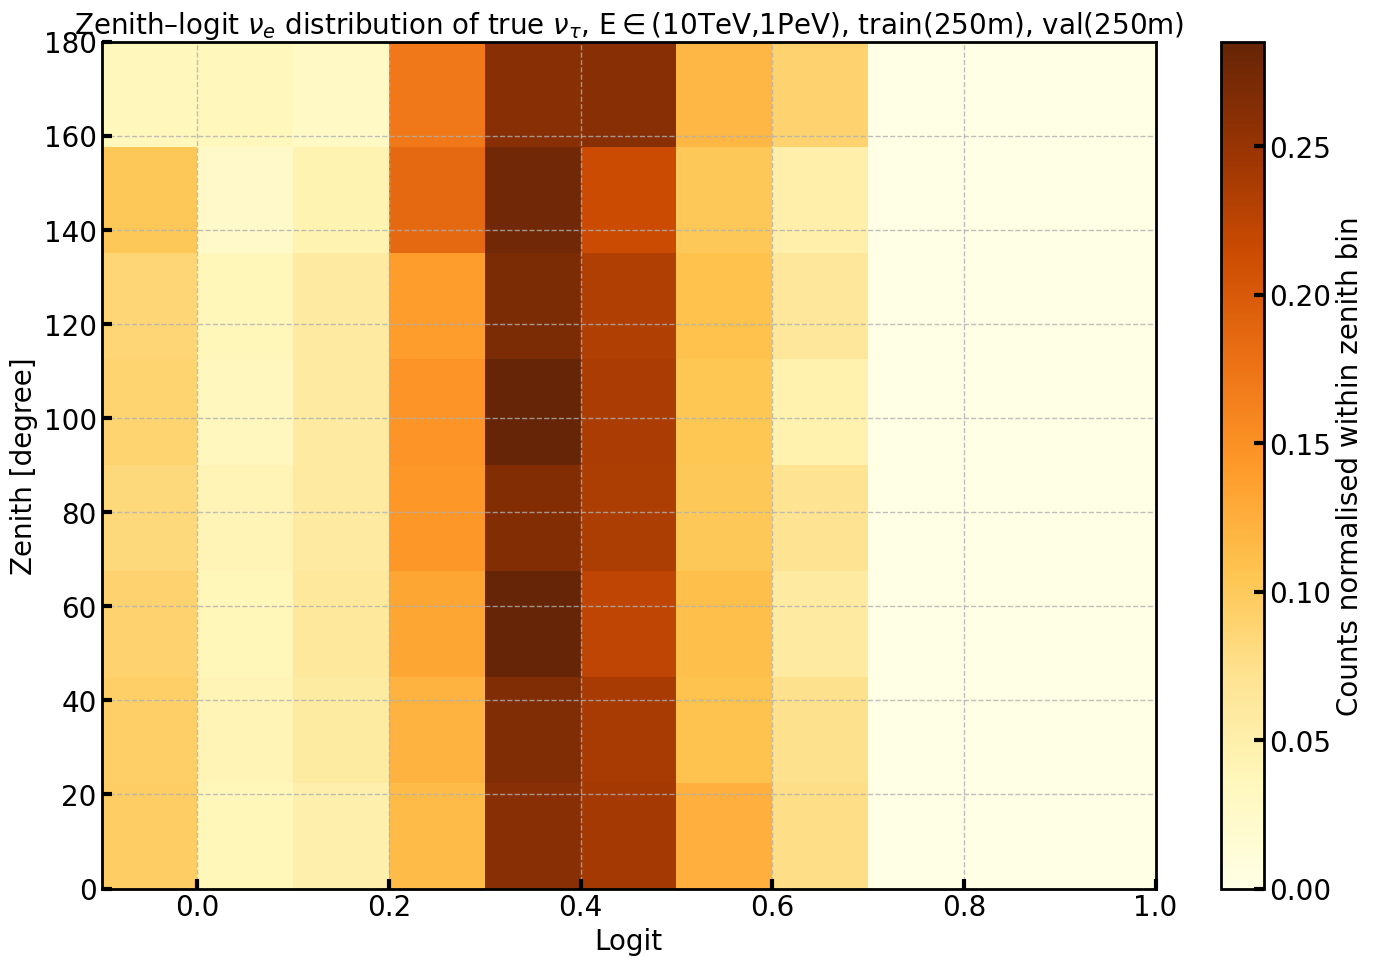

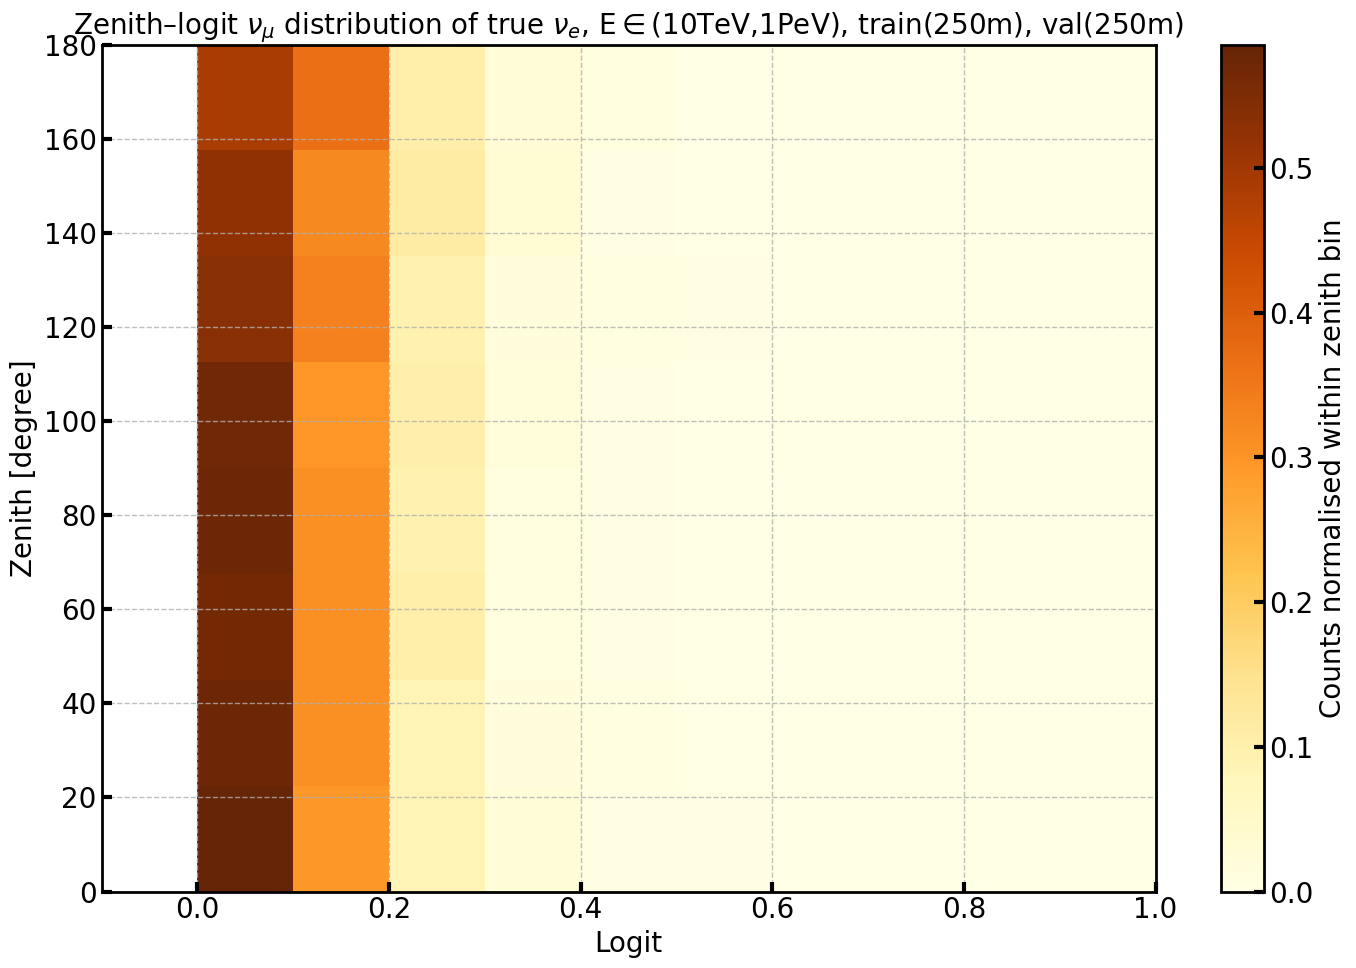

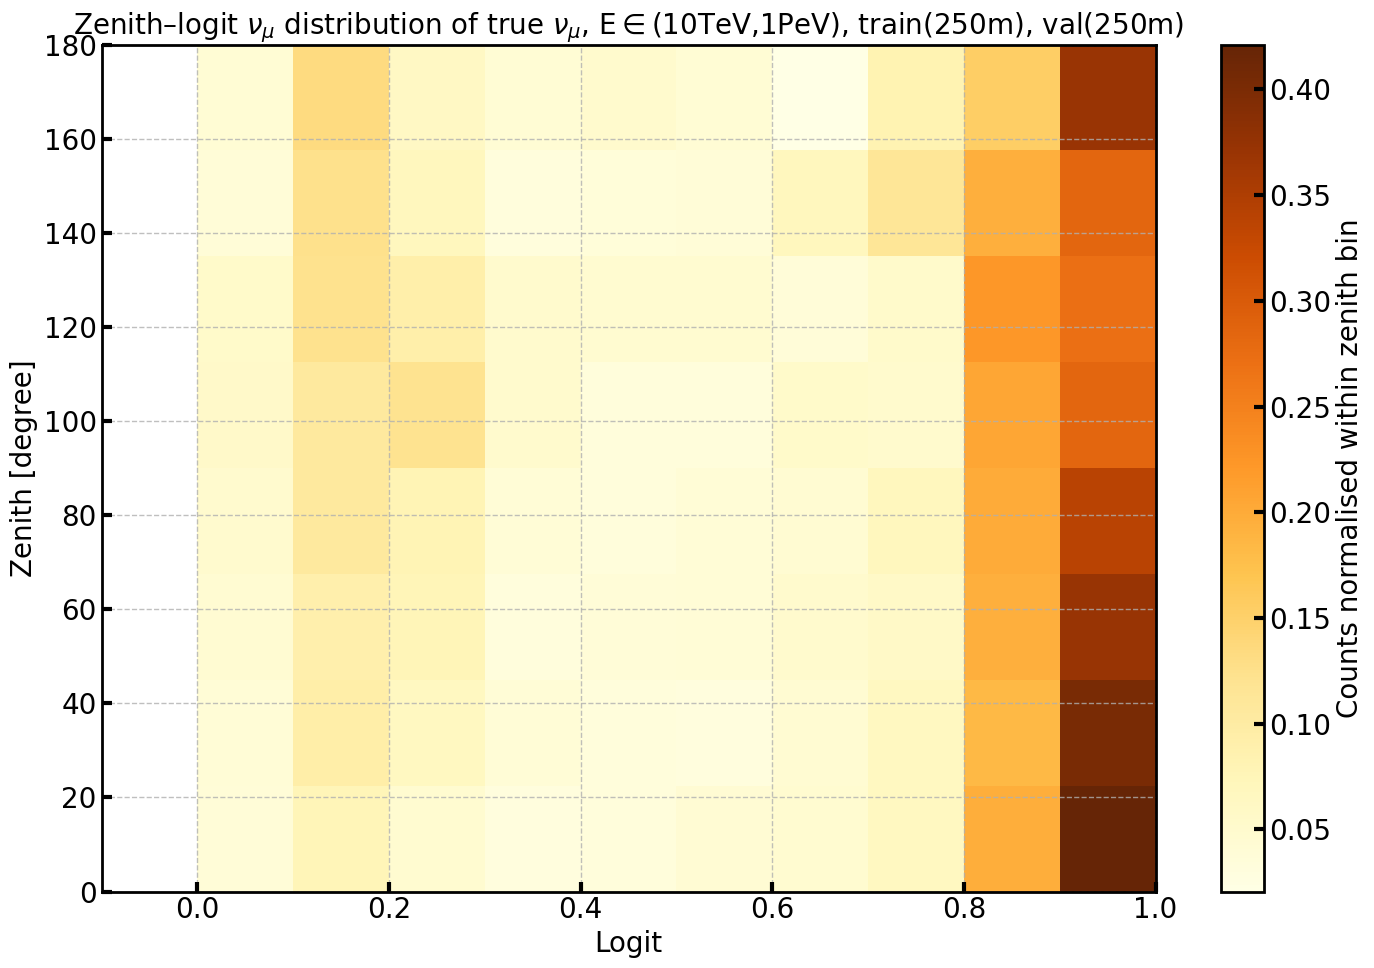

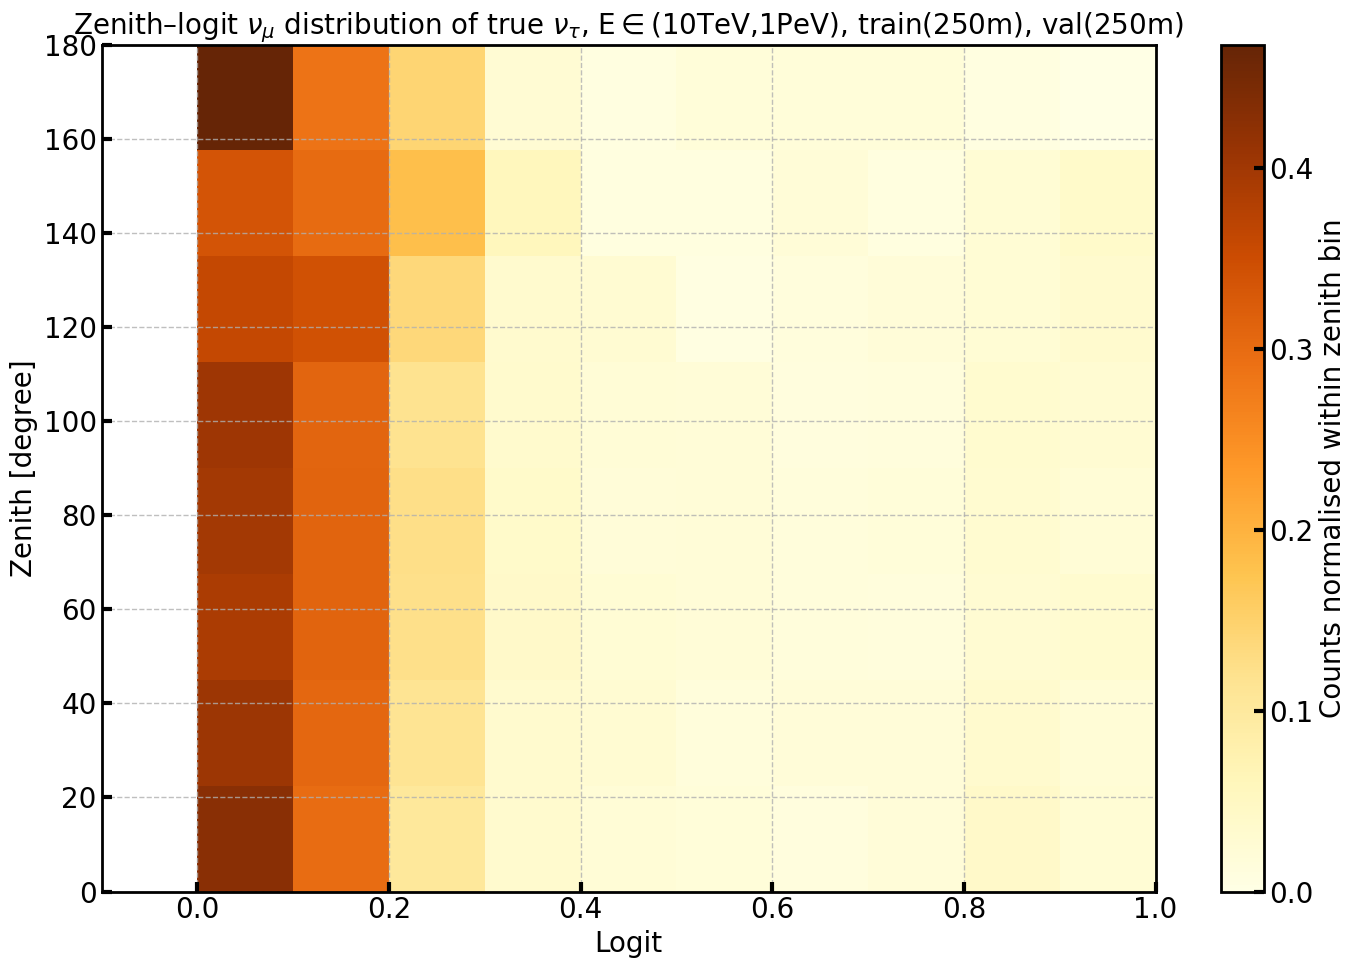

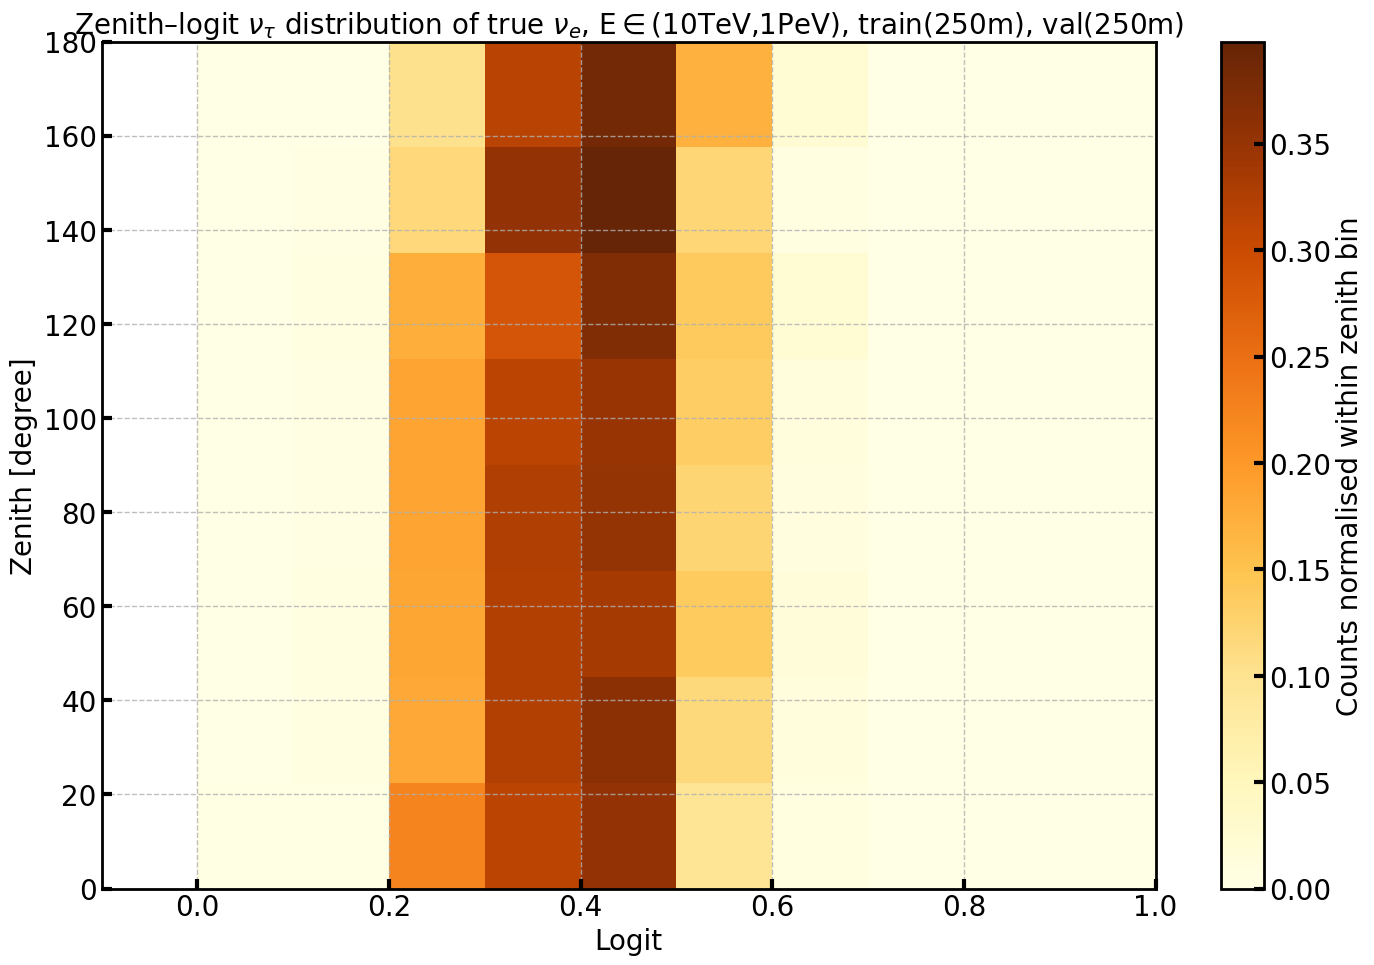

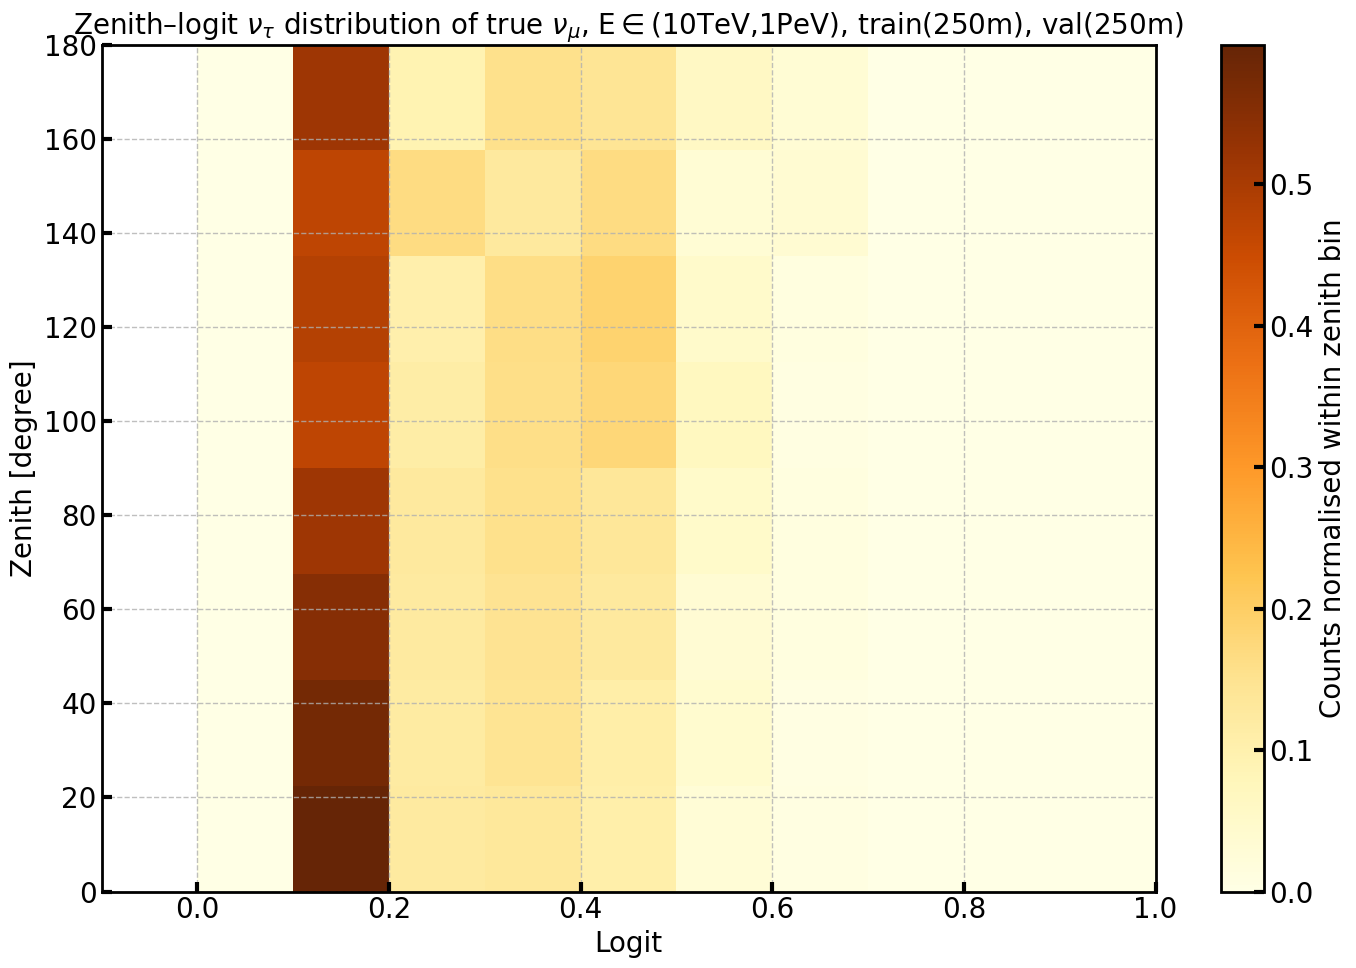

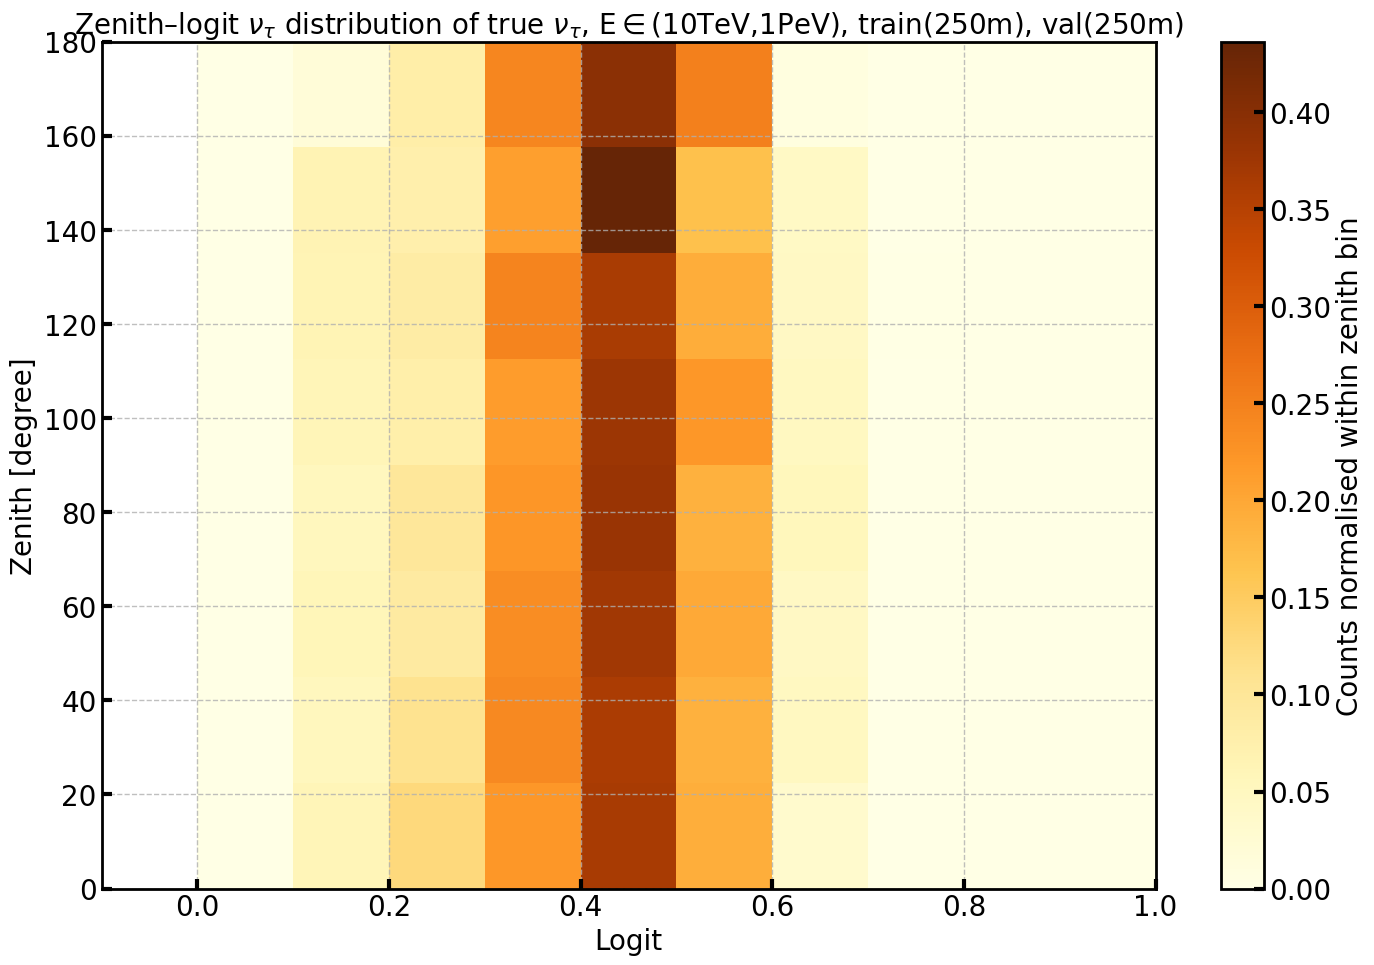

In [229]:
plot_csvs_zenith(csvs_medium)